In [1]:
# @title
from google.colab import files
uploaded = files.upload()


Saving New_data_2024.xlsx to New_data_2024.xlsx


In [2]:
# @title
# ==== Colab-ready cleaner for Sheet13 (daily prices) with SIMPLE tickers ====
# Outputs:
#   /content/cleaned_prices_tickers.xlsx
#   /content/log_returns_tickers.xlsx
#   /content/monthly_log_returns_tickers.xlsx
#   /content/monthly_simple_returns_tickers.xlsx
#
# Prints first 10 rows for all tables.

import pandas as pd
import numpy as np
import re

# ----------------- CONFIG -----------------
FILE_PATH  = "/content/New_data_2024.xlsx"   # upload to Colab or mount Drive
SHEET_NAME = "Sheet13"                       # daily prices sheet
MAX_SCAN_COLS = 8                            # leading cols to scan for Date
SCAN_HEADER_ROWS = 10                        # top rows to auto-detect Code row
# ------------------------------------------

# ---------- date parsing (overflow-safe) ----------
def parse_candidate_dates(s: pd.Series) -> pd.Series:
    """Parse Excel serials + strict ISO strings, avoiding overflow."""
    s = s.copy()
    s_num = pd.to_numeric(s, errors="coerce").astype("float64")
    mask = (s_num >= 20000) & (s_num <= 80000)  # ~1954–2119

    out = pd.Series(pd.NaT, index=s.index, dtype="datetime64[ns]")
    if mask.any():
        origin = pd.Timestamp("1899-12-30")
        out.loc[mask] = origin + pd.to_timedelta(s_num.loc[mask], unit="D")

    s_str = s.where(~mask).astype(str)
    dt1 = pd.to_datetime(s_str, format="%Y-%m-%d %H:%M:%S", errors="coerce")
    dt2 = pd.to_datetime(s_str, format="%Y-%m-%d", errors="coerce")
    return out.fillna(dt1).fillna(dt2)

# ---------- helpers ----------
def make_unique(cols):
    seen, out = {}, []
    for c in cols:
        name = c if isinstance(c, str) else ("" if pd.isna(c) else str(c))
        if name in seen:
            seen[name] += 1
            name = f"{name}__{seen[name]}"
        else:
            seen[name] = 0
        out.append(name)
    return out

def clean_code(x) -> str | None:
    """Simplify vendor code to a compact ticker."""
    x = (str(x) if pd.notna(x) else "").strip()
    if not x:
        return None
    x = re.sub(r"^(@|[A-Z]{1,3}:)", "", x)   # @, C:, U:, SA:, DK: ...
    x = re.sub(r"\([^)]*\)", "", x)          # remove (...) suffixes
    x = x.upper().replace(" ", "")
    return x or None

def name_to_fallback_ticker(name) -> str | None:
    s = str(name) if pd.notna(name) else ""
    if not s:
        return None
    s = s.split(" - ")[0]
    s = s.upper().replace("&", " ")
    s = re.sub(r"[^A-Z0-9]+", "", s)
    return s[:24] if s else None

CODE_PATTERN = re.compile(r"^(@|[A-Z]{1,3}:)?[A-Z0-9][A-Z0-9.\-]*\([^)]*\)$")
def detect_code_row(df: pd.DataFrame, scan_rows: int = 10) -> int | None:
    best_row, best_score = None, -1
    cols = df.shape[1]
    for r in range(min(scan_rows, len(df))):
        score = 0
        row = df.iloc[r].astype(str).fillna("")
        for j in range(cols):
            cell = row.iat[j].strip()
            if CODE_PATTERN.match(cell):
                score += 2
            elif "(" in cell and ")" in cell:
                score += 1
        if score > best_score:
            best_row, best_score = r, score
    return best_row

def find_date_col_and_first_row(df: pd.DataFrame, max_scan_cols: int = 8):
    best_col, best_nnz, best_series = None, -1, None
    for c in range(min(max_scan_cols, df.shape[1])):
        parsed = parse_candidate_dates(df[c])
        nnz = parsed.notna().sum()
        if nnz > best_nnz:
            best_nnz, best_col, best_series = nnz, c, parsed
    if best_col is None or best_nnz == 0:
        raise RuntimeError("Could not find any column with parseable dates.")
    first_idx = best_series.first_valid_index()
    if first_idx is None:
        raise RuntimeError("Date column found, but no valid starting date index detected.")
    return int(best_col), int(first_idx)

# ----------------- LOAD RAW -----------------
raw = pd.read_excel(FILE_PATH, sheet_name=SHEET_NAME, header=None)

# Detect Code row (for tickers) and Date column/first row
code_row_idx = detect_code_row(raw, SCAN_HEADER_ROWS)
if code_row_idx is None:
    raise RuntimeError("Could not detect the Code row automatically.")

date_col, first_data_row = find_date_col_and_first_row(raw, MAX_SCAN_COLS)

# Grab Code/Name rows (for fallback)
code_row_vals = list(raw.iloc[code_row_idx].tolist())
name_row_idx = code_row_idx - 1 if code_row_idx > 0 else None
name_row_vals = list(raw.iloc[name_row_idx].tolist()) if name_row_idx is not None else [None] * len(code_row_vals)

# Build final headers: Date at detected date_col, tickers elsewhere
data = raw.iloc[first_data_row:].copy()

final_cols = []
for j in range(data.shape[1]):
    if j == date_col:
        final_cols.append("Date")
        continue
    ticker = clean_code(code_row_vals[j] if j < len(code_row_vals) else None)
    if not ticker:
        nm = name_row_vals[j] if j < len(name_row_vals) else None
        ticker = name_to_fallback_ticker(nm) or f"TICKER{j}"
    final_cols.append(ticker)
data.columns = make_unique(final_cols)

# Parse Date, numeric coercion, cleanup
data["Date"] = parse_candidate_dates(data["Date"])
data = data.dropna(subset=["Date"]).sort_values("Date")

# If the sheet has duplicate calendar days, keep the last price of that day
data = (data
        .groupby("Date", as_index=False)
        .last()
        .sort_values("Date")
        .reset_index(drop=True))

num_cols = [c for c in data.columns if c != "Date"]
for c in num_cols:
    data[c] = pd.to_numeric(data[c], errors="coerce")

# Drop fully-empty columns
empty_cols = [c for c in num_cols if data[c].notna().sum() == 0]
if empty_cols:
    data = data.drop(columns=empty_cols)
    num_cols = [c for c in data.columns if c != "Date"]

# Gap-fill within each series: **forward fill only** (no backfill)
data[num_cols] = data[num_cols].ffill()

# ---------- DAILY LOG RETURNS ----------
logret = pd.DataFrame(index=data.index, columns=["Date"] + num_cols)
logret["Date"] = data["Date"]
with np.errstate(divide="ignore", invalid="ignore"):
    # vectorized: log(P_t / P_{t-1})
    logret[num_cols] = np.log(data[num_cols].div(data[num_cols].shift(1)))

# drop the first row per series if entirely NaN
logret = logret.dropna(how="all", subset=num_cols).reset_index(drop=True)

# ---------- MONTHLY LOG RETURNS (sum of daily logs per month) ----------
logret["Month"] = logret["Date"].dt.to_period("M")
monthly_log = (logret
               .groupby("Month")[num_cols]
               .sum(min_count=1))
monthly_log.index = monthly_log.index.to_timestamp("M")
monthly_log.index.name = "Date"

# ---------- MONTHLY SIMPLE RETURNS ----------
# (A) From monthly log returns: r = exp(sum log) - 1
monthly_simple_from_log = np.expm1(monthly_log)
monthly_simple_from_log.index.name = "Date"

# (B) From prices directly: r = P_me / P_prev_me - 1
prices_m = (data.set_index("Date")[num_cols]
            .resample("M").last())
monthly_simple_from_prices = prices_m.pct_change()
monthly_simple_from_prices.index.name = "Date"

# Optional: small consistency check between the two methods
# (They should match closely; differences can appear if daily gaps exist.)
diff = (monthly_simple_from_log - monthly_simple_from_prices).abs()
max_abs_diff = diff.max().max(skipna=True)
if pd.notna(max_abs_diff) and max_abs_diff > 1e-6:
    print(f"[note] Max abs diff between simple-from-log and simple-from-prices: {max_abs_diff:,.6g}")

# ----------------- SAVE OUTPUTS -----------------
prices_out   = "/content/cleaned_prices_tickers.xlsx"
rets_out     = "/content/log_returns_tickers.xlsx"
mrets_out    = "/content/monthly_log_returns_tickers.xlsx"
msimple_out  = "/content/monthly_simple_returns_tickers.xlsx"

data.to_excel(prices_out, index=False)
logret.drop(columns=["Month"]).to_excel(rets_out, index=False)
monthly_log.to_excel(mrets_out)
monthly_simple_from_prices.to_excel(msimple_out)

print(f"✅ Prices saved:                     {prices_out}  shape={data.shape}")
print(f"✅ Log-returns saved:                {rets_out}  shape={logret.drop(columns=['Month']).shape}")
print(f"✅ Monthly log-returns saved:        {mrets_out}  shape={monthly_log.shape}")
print(f"✅ Monthly SIMPLE returns saved:     {msimple_out}  shape={monthly_simple_from_prices.shape}")

# ---- Print first 10 rows (wide-friendly) ----
print("\nPreview: Prices (first 10 rows)")
with pd.option_context('display.max_columns', None, 'display.width', 220):
    print(data.head(10).to_string(index=False))

print("\nPreview: Log-returns (first 10 rows)")
with pd.option_context('display.max_columns', None, 'display.width', 220):
    print(logret.drop(columns=["Month"]).head(10).to_string(index=False))

print("\nPreview: Monthly log-returns (first 10 rows)")
with pd.option_context('display.max_columns', None, 'display.width', 220):
    print(monthly_log.head(10))

print("\nPreview: Monthly SIMPLE returns (first 10 rows)")
with pd.option_context('display.max_columns', None, 'display.width', 220):
    print(monthly_simple_from_prices.head(10))


/tmp/ipython-input-4104038439.py:139: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  .last()
/tmp/ipython-input-4104038439.py:181: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M").last())


✅ Prices saved:                     /content/cleaned_prices_tickers.xlsx  shape=(3566, 162)
✅ Log-returns saved:                /content/log_returns_tickers.xlsx  shape=(3565, 162)
✅ Monthly log-returns saved:        /content/monthly_log_returns_tickers.xlsx  shape=(164, 161)
✅ Monthly SIMPLE returns saved:     /content/monthly_simple_returns_tickers.xlsx  shape=(165, 161)

Preview: Prices (first 10 rows)
      Date   VNP   AYI  ADH  AEIS   AFC    APD  AMRC  AMSC  ASYS    BMI  BLDP   BLX  CSIQ  CWR  CLYU   IHDH   NEE  ENEL   IBE  DEN   VEW   SSE   XEL  ECP  EDPR  ENPH   VERB  ENR   PCG   GAM  XSHL   ERG  PLUG  SCAT  SEDG  SEM  CENZ    DQ  DRX   FKR  FSLR  NEL0  NEOP  AQN   ALE  AY   AVA  BE  CTW  DF9  ECV  ENRG  ENLT  FCEL  GPRE    HYC    HE   IDA  INE   JKS  MELZ  NDX1   NPI   ORA  REGI  RNVA  SHLS  NOVA  RUN  VBK  XIE1   ABIO  FGN  EOLU  SAME  HE1  MAXN  MCPH  MBTN  PCELL   S92  TPIC   UNS  BLDP__1  BEPC  XGST  EBR   CIG   ELP  FLAT  APD__1  AMRC__1  AMSC__1  ASYS__1  BMI__1  CWR__1 

In [3]:
# @title
# ==== MCAP cleaner with SIMPLE tickers (auto-detect code row) ====
# - Ensures Date is FIRST column
# - Compact, uniform tickers
# - No backfill; capped forward-fill only
# - COLLAPSES TO MONTH-END (to match monthly returns)
# - Prints NA diagnostics + first 10 rows
# - Saves cleaned sheet

import pandas as pd
import numpy as np
import re

# ----------------- CONFIG -----------------
FILE_PATH   = "/content/New_data_2024.xlsx"
SHEET_NAME  = "MCAP"
MAX_SCAN_COLS = 8
SCAN_HEADER_ROWS = 10
SAVE_OUTPUT = True
OUT_PATH    = "/content/cleaned_mcap_tickers.xlsx"

# knobs
STALE_CAP_MONTHS = 3   # forward-fill at most this many rows
MIN_OBS = 36           # drop tickers with < MIN_OBS valid months (None to disable)
# ------------------------------------------

def parse_dates_robust(s: pd.Series) -> pd.Series:
    s_num = pd.to_numeric(s, errors="coerce").astype("float64")
    mask_serial = (s_num >= 20000) & (s_num <= 80000)
    out = pd.Series(pd.NaT, index=s.index, dtype="datetime64[ns]")
    if mask_serial.any():
        origin = pd.Timestamp("1899-12-30")
        out.loc[mask_serial] = origin + pd.to_timedelta(s_num.loc[mask_serial], unit="D")
    s_str = s.where(~mask_serial).astype(str)
    dt1 = pd.to_datetime(s_str, format="%Y-%m-%d %H:%M:%S", errors="coerce")
    dt2 = pd.to_datetime(s_str, format="%Y-%m-%d", errors="coerce")
    return out.fillna(dt1).fillna(dt2)

def make_unique(cols):
    seen, out = {}, []
    for c in cols:
        name = c if isinstance(c, str) else ("" if pd.isna(c) else str(c))
        if name in seen:
            seen[name] += 1
            name = f"{name}__{seen[name]}"
        else:
            seen[name] = 0
        out.append(name)
    return out

def clean_code(x) -> str | None:
    x = (str(x) if pd.notna(x) else "").strip()
    if not x:
        return None
    x = re.sub(r"^(@|[A-Z]{1,3}:)", "", x)
    x = re.sub(r"\([^)]*\)", "", x)
    x = x.upper()
    x = re.sub(r"[.\-\/\s]", "", x)
    x = re.sub(r"[^A-Z0-9]", "", x)
    if len(x) > 3 and re.search(r"[0-9]$", x):
        x = x[:-1]
    return x or None

CODE_PATTERN = re.compile(r"^(@|[A-Z]{1,3}:)?[A-Z0-9][A-Z0-9.\-]*\([^)]*\)$")
def detect_code_row(df: pd.DataFrame, scan_rows: int = 10) -> int | None:
    best_row, best_score = None, -1
    for r in range(min(scan_rows, len(df))):
        row = df.iloc[r].astype(str).fillna("")
        score = 0
        for cell in row:
            cell = cell.strip()
            if CODE_PATTERN.match(cell): score += 2
            elif "(" in cell and ")" in cell: score += 1
        if score > best_score:
            best_row, best_score = r, score
    return best_row

def find_date_column_and_first_row(df: pd.DataFrame, max_scan_cols: int = 8):
    best_col, best_nnz, best_series = None, -1, None
    for c in range(min(max_scan_cols, df.shape[1])):
        parsed = parse_dates_robust(df[c])
        nnz = parsed.notna().sum()
        if nnz > best_nnz:
            best_col, best_nnz, best_series = c, nnz, parsed
    if best_col is None or best_nnz == 0:
        raise RuntimeError("Could not find any column with parseable dates.")
    first_idx = best_series.first_valid_index()
    if first_idx is None:
        raise RuntimeError("Date column found, but no valid starting date index detected.")
    return int(best_col), int(first_idx)

# ----------------- LOAD & CLEAN -----------------
raw = pd.read_excel(FILE_PATH, sheet_name=SHEET_NAME, header=None)

code_row_idx = detect_code_row(raw, SCAN_HEADER_ROWS)
if code_row_idx is None:
    raise RuntimeError("Could not detect the Code row automatically.")
raw_codes = raw.iloc[code_row_idx].tolist()
code_row_vals = [clean_code(x) for x in raw_codes]

date_col, date_row_idx = find_date_column_and_first_row(raw, MAX_SCAN_COLS)

data = raw.iloc[date_row_idx:].copy()

final_cols = []
for j in range(data.shape[1]):
    if j == date_col:
        final_cols.append("Date")
    else:
        t = code_row_vals[j] if j < len(code_row_vals) else None
        final_cols.append(t if (t is not None and len(t) > 0) else f"TICKER{j}")
data.columns = make_unique(final_cols)

if "Date" not in data.columns:
    raise RuntimeError("Internal error: Date column not found after header assignment.")
num_cols = [c for c in data.columns if c != "Date"]
data = data[["Date"] + num_cols]

data["Date"] = parse_dates_robust(data["Date"])
data = data.dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)

for c in num_cols:
    data[c] = pd.to_numeric(data[c], errors="coerce")

# drop all-NaN tickers
empty_cols = [c for c in num_cols if data[c].notna().sum() == 0]
if empty_cols:
    data = data.drop(columns=empty_cols)
    num_cols = [c for c in data.columns if c != "Date"]

# capped forward-fill only (no backfill)
data[num_cols] = data[num_cols].ffill(limit=STALE_CAP_MONTHS)

# ----------------- NEW: collapse to month-end -----------------
data["Month"] = data["Date"].dt.to_period("M")
# take the last row seen in each month (after capped ffill);
# this keeps NaN if a ticker never had data in that month
data = (
    data.sort_values("Date")
        .groupby("Month", as_index=False)
        .last()
)
data["Date"] = data["Month"].dt.to_timestamp("M")  # stamp at month-end
data = data.drop(columns="Month").sort_values("Date").reset_index(drop=True)
num_cols = [c for c in data.columns if c != "Date"]
# ---------------------------------------------------------------

# enforce minimum monthly coverage
if MIN_OBS is not None and MIN_OBS > 0:
    keep = [c for c in num_cols if data[c].notna().sum() >= MIN_OBS]
    dropped_for_coverage = sorted(set(num_cols) - set(keep))
    data = data[["Date"] + keep]
else:
    dropped_for_coverage = []

# diagnostics
na_share = data.set_index("Date").isna().mean().sort_values(ascending=False)
print("=== MCAP NaN share by ticker (top 15) ===")
print((na_share.head(15) * 100).round(1).astype(str) + "%")
print("\nDropped all-NaN tickers:", len(empty_cols))
if dropped_for_coverage:
    print(f"Dropped for insufficient coverage (<{MIN_OBS} valid months): {len(dropped_for_coverage)}")

# save + preview
if SAVE_OUTPUT:
    data.to_excel(OUT_PATH, index=False)
    print(f"\n✅ cleaned_mcap_tickers.xlsx saved to: {OUT_PATH}  shape={data.shape}")

print(f"Detected code row index: {code_row_idx}, date column index: {date_col}, first data row: {date_row_idx}")

print("\nPreview (first 10 rows):")
with pd.option_context('display.max_columns', None, 'display.width', 220):
    print(data.head(10).to_string(index=False))


/tmp/ipython-input-2106659052.py:135: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["Month"] = data["Date"].dt.to_period("M")


=== MCAP NaN share by ticker (top 15) ===
SHLS    76.2%
ENR     68.9%
MAXN    68.9%
BEPC    68.9%
DF9     61.6%
HE1     61.6%
NOVA    61.6%
NEOP    54.3%
BE      54.3%
XIE     52.4%
RNVA    40.9%
DEN     39.6%
TPIC    39.6%
SEDG    32.3%
RUN     32.3%
dtype: object

Dropped all-NaN tickers: 16

✅ cleaned_mcap_tickers.xlsx saved to: /content/cleaned_mcap_tickers.xlsx  shape=(164, 161)
Detected code row index: 4, date column index: 0, first data row: 6

Preview (first 10 rows):
      Date      VNP       AYI     AEIS     AFC        APD     AMRC     AMSC    ASYS      BMI    BLDP      BLX     CSIQ     CWR       CLYU       IHDH        NEE       ENEL        IBE  DEN        VEW        SSE        XEL       ECP      EDPR  ENPH      VERB  ENR        PCG      GAM       XSHL       ERG    PLUG  SCAT  SEDG     SEM      CENZ      DQ       DRX      FKR      FSLR      NEL  NEOP      AQN       ALE  AY       AVA  BE  CTW  DF9      ECV     ENRG    ENLT     FCEL     GPRE          HYC        HE       IDA    

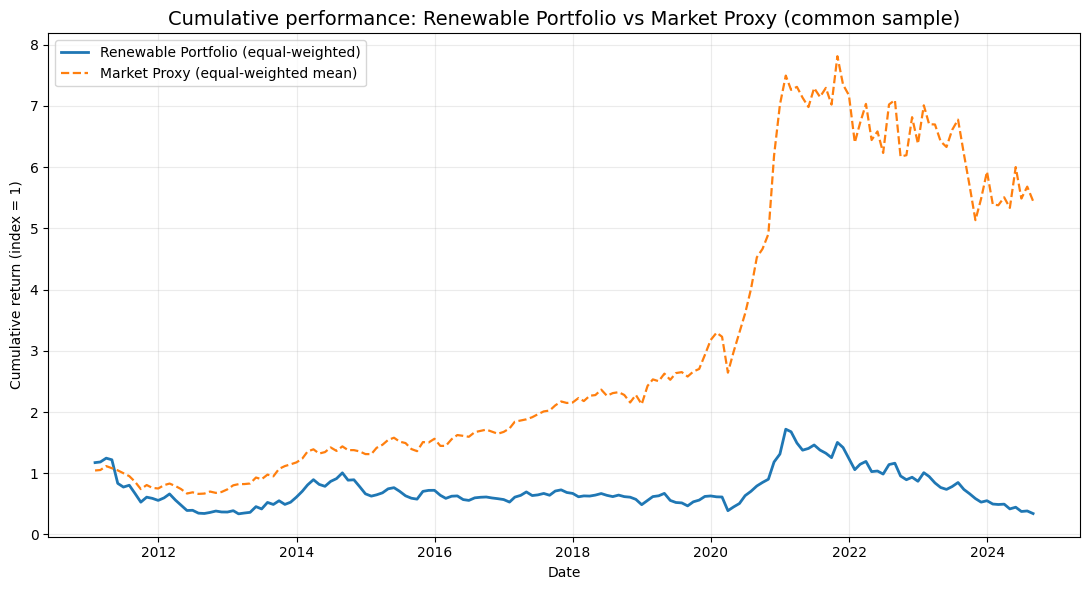

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Load data (adjust filenames if necessary) ---
renewable_df = pd.read_excel("monthly_log_returns_tickers.xlsx", index_col="Date", parse_dates=True)
market_df    = pd.read_excel("monthly_simple_returns_tickers.xlsx", index_col="Date", parse_dates=True)

# --- Inspect and align dates (optional) ---
# Align both to common index to avoid plotting mismatched dates
common_index = renewable_df.index.intersection(market_df.index)
renewable_df = renewable_df.loc[common_index].sort_index()
market_df    = market_df.loc[common_index].sort_index()

# --- Create market proxy: equal-weighted average of all available columns ---
market_proxy = market_df.mean(axis=1)

# --- Create renewable portfolio:
# Option 1: supply your own list of renewable tickers (preferred)
renewable_tickers = [
    # Example: put your renewable tickers here, e.g. "RNW","BEPC","ENPH","PLUG","FSLR"
    # If you don't know the exact names, leave list empty and code will fallback
]

# Fallback heuristic: pick tickers with substrings common in renewables (you can edit)
if len(renewable_tickers) == 0:
    substrings = ["RE", "REN", "SOL", "WIND", "ENER", "TPIL", "PV", "CELL", "PLUG", "FUEL", "HYD", "GREEN", "RW"]
    # This heuristic is crude; edit/remove as needed.
    renewable_tickers = [col for col in renewable_df.columns
                         if any(sub.lower() in col.lower() for sub in substrings)]

# Ensure tickers exist
renewable_tickers = [t for t in renewable_tickers if t in renewable_df.columns]
if len(renewable_tickers) == 0:
    # fallback: if no renewables identified, use a subset (e.g., first 20 columns) as a temporary portfolio
    renewable_tickers = renewable_df.columns[:20].tolist()
    print("No renewable tickers specified/found. Using first 20 tickers as a temporary renewable portfolio:", renewable_tickers)

# Compute equal-weighted portfolio returns
portfolio_returns = renewable_df[renewable_tickers].mean(axis=1)

# --- Compute cumulative returns (index starts at 1)
cum_portfolio = (1 + portfolio_returns).cumprod()
cum_market    = (1 + market_proxy).cumprod()

# --- Optional: smooth for visual clarity (uncomment if desired)
# cum_portfolio = cum_portfolio.rolling(window=3, min_periods=1).mean()
# cum_market = cum_market.rolling(window=3, min_periods=1).mean()

# --- Plotting
plt.figure(figsize=(11,6))
plt.plot(cum_portfolio, label="Renewable Portfolio (equal-weighted)", linewidth=2)
plt.plot(cum_market, label="Market Proxy (equal-weighted mean)", linewidth=1.6, linestyle='--')
plt.title("Cumulative performance: Renewable Portfolio vs Market Proxy (common sample)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Cumulative return (index = 1)")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()

# --- Save figure for LaTeX (high resolution)
plt.savefig("renewable_market_trend.png", dpi=300, bbox_inches="tight")
plt.show()





In [5]:
# @title MTBV cleaner + 1/MTBV with month-end alignment
import pandas as pd
import numpy as np
import re
from collections import Counter

# ======= CONFIG =======
FILE  = "New_data_2024.xlsx"     # change path if needed
SHEET = "MTBV"

OUT_CLEAN_XLSX = "MTBV_cleaned_all_simplified.xlsx"
OUT_INV_XLSX   = "INV_MTBV.xlsx"     # 1/MTBV (book-to-market)

# Row layout (Datastream-style)
ROW_NAME       = 3            # company names (not used)
ROW_CODE       = 4            # codes like U:AYI(MTBV)
ROW_CURRENCY   = 5            # currencies (U$, C$, £, € ...)
ROW_DATA_START = 6            # first data row
DATE_COL       = 0            # Date column

# ======= HELPERS =======
def simplify_code(code):
    """Turn 'U:AYI(MTBV)' or '@TSLA(MTBV)' -> 'AYI' / 'TSLA'."""
    if pd.isna(code):
        return None
    s = str(code).strip()
    s = re.sub(r"^.*?:", "", s)      # drop prefix before ':'
    s = s.replace("@", "")           # drop '@'
    s = re.sub(r"\(.*?\)", "", s)    # drop '(...)' e.g. (MTBV)
    s = re.sub(r"[^A-Za-z0-9.\-]", "", s)
    return s or None

def make_unique(names):
    """Ensure column names are unique: AYI, AYI_2, AYI_3, ..."""
    out, ctr = [], Counter()
    for n in names:
        if n is None or n == "":
            out.append(None)
            continue
        ctr[n] += 1
        out.append(n if ctr[n] == 1 else f"{n}_{ctr[n]}")
    return out

# ======= LOAD & CLEAN =======
raw = pd.read_excel(FILE, sheet_name=SHEET, header=None)

# Parse dates from DATE_COL; keep only valid rows
date_col = raw.iloc[ROW_DATA_START:, DATE_COL]
dates = pd.to_datetime(date_col, errors="coerce")

# if parsing fails (Excel serials), try that too
if dates.isna().all():
    serial = pd.to_numeric(date_col, errors="coerce")
    dates = pd.to_datetime(serial, unit="D", origin="1899-12-30", errors="coerce")

valid_mask = dates.notna().to_numpy()
date_index = dates[valid_mask].to_numpy()

# Build simplified column labels from Code row
codes_row = raw.iloc[ROW_CODE, :]
labels, cols_idx = [], []
for j in range(raw.shape[1]):
    if j == DATE_COL:
        continue
    lab = simplify_code(codes_row[j])
    labels.append(lab)
    cols_idx.append(j)

# Make names unique to avoid collisions after simplification
labels = make_unique(labels)

# Build data block (numeric)
data_dict = {}
for lab, j in zip(labels, cols_idx):
    if lab is None or lab == "":
        continue
    vals = pd.to_numeric(raw.iloc[ROW_DATA_START:, j], errors="coerce").to_numpy()
    data_dict[lab] = vals[valid_mask]

clean = pd.DataFrame(data_dict, index=pd.to_datetime(date_index)).sort_index()

# Optional: drop all-NaN columns
clean = clean.dropna(axis=1, how="all")

# Ensure float dtype (good for division later)
clean = clean.apply(pd.to_numeric, errors="coerce").astype("float64")

# ======= COLLAPSE TO TRUE MONTH-END & ALIGN FULL GRID =======
# 1) add Month period, 2) TRUE last row per month, 3) stamp exact month-end,
# 4) reindex to COMPLETE month-end range (missing months -> NaN rows)

tmp = clean.copy()
tmp = tmp.reset_index().rename(columns={"index":"Date"})
tmp["Month"] = tmp["Date"].dt.to_period("M")

# True last row per month (preserves NaN if the last row had NaN)
try:
    last_per_month = (
        tmp.sort_values("Date")
           .groupby("Month", as_index=False)
           .nth(-1, dropna='all')       # pandas >= 1.5
    )
except TypeError:
    # Fallback for older pandas
    last_per_month = (
        tmp.sort_values("Date")
           .groupby("Month", as_index=False)
           .apply(lambda g: g.iloc[[-1]])
           .reset_index(drop=True)
    )

# Stamp exact month-end
last_per_month["Date"] = last_per_month["Month"].dt.to_timestamp("M")
last_per_month = last_per_month.drop(columns="Month").sort_values("Date").reset_index(drop=True)

# Build full month-end index
start_m = last_per_month["Date"].iloc[0].to_period("M")
end_m   = last_per_month["Date"].iloc[-1].to_period("M")
full_m  = pd.period_range(start=start_m, end=end_m, freq="M")
full_dates = full_m.to_timestamp("M")

# Reindex to full month-end grid
clean_monthly = (
    last_per_month.set_index("Date")
                  .reindex(full_dates)
                  .rename_axis("Date")
                  .sort_index()
)

# ======= SAVE CLEANED (MTBV, monthly) =======
print("\n=== Preview (MTBV cleaned, monthly): first 10 rows × up to 10 cols ===")
print(clean_monthly.iloc[:10, :min(10, clean_monthly.shape[1])])
clean_monthly.to_excel(OUT_CLEAN_XLSX)
print(f"\n✅ Saved cleaned MTBV (monthly, month-end): {OUT_CLEAN_XLSX}")
print("Rows:", clean_monthly.shape[0], "  Columns:", clean_monthly.shape[1])

# ======= INVERT TO 1/MTBV (BOOK-TO-MARKET) =======
# Treat zeros and non-positive MTBV as missing to avoid inf/invalid B/M
mtbv_masked = clean_monthly.copy()
mtbv_masked[(mtbv_masked == 0.0) | (mtbv_masked <= 0.0)] = np.nan  # remove the <=0.0 part if you prefer to keep negatives

inv = 1.0 / mtbv_masked

# Optional: drop all-NaN columns after inversion
inv = inv.dropna(axis=1, how="all")

# ======= SAVE INVERTED =======
print("\n=== Preview (INV_MTBV = 1/MTBV, monthly): first 10 rows × up to 10 cols ===")
print(inv.iloc[:10, :min(10, inv.shape[1])])
inv.to_excel(OUT_INV_XLSX)
print(f"\n✅ Saved inverted (book-to-market, monthly, month-end): {OUT_INV_XLSX}")
print("Rows:", inv.shape[0], " Columns:", inv.shape[1])



=== Preview (MTBV cleaned, monthly): first 10 rows × up to 10 cols ===
             VNP   AYI  AEIS    AFC   APD  AMRC  AMSC  ASYS   BMI   BLX
Date                                                                   
2011-01-31  0.95  3.38  1.47  13.15  3.35  2.57  5.11  2.10  3.79  1.00
2011-02-28  0.93  3.20  1.69  15.30  3.32  2.51  5.17  2.13  3.50  1.13
2011-03-31  1.27  3.20  1.69  14.65  3.33  2.35  4.51  1.79  3.23  1.01
2011-04-30  1.25  3.45  1.72  16.62  3.36  2.38  7.54  2.06  3.46  1.04
2011-05-31  1.92  3.34  1.44  12.43  3.46  2.78  3.60  1.84  3.17  1.05
2011-06-30  1.78  3.35  1.55  11.84  3.37  2.47  2.49  1.74  3.10  1.08
2011-07-31  1.88  3.20  1.60  10.28  3.53  2.55  2.73  1.75  3.15  0.97
2011-08-31  1.73  2.76  1.12  10.94  3.26  2.36  2.20  1.52  3.07  0.99
2011-09-30  1.77  2.32  1.03  10.37  3.00  2.03  2.03  0.86  2.91  0.88
2011-10-31  1.46  1.77  0.86   7.84  2.43  1.66  1.06  0.87  2.34  0.86

✅ Saved cleaned MTBV (monthly, month-end): MTBV_cleaned_all_sim

In [6]:
# @title
import numpy as np
import pandas as pd

# =========================
# Files
# =========================
MCAP_XLSX = "cleaned_mcap_tickers.xlsx"       # monthly MCAP (prefer month-end index)
RET_XLSX  = "log_returns_tickers.xlsx"        # returns (daily or monthly; log or simple)
OUT_SMB   = "SMB_series.xlsx"                 # Excel with SMB (and diagnostics)

# =========================
# Knobs
# =========================
USE_LAGGED_MCAP       = True       # use t-1 MCAP to sort at t
RET_IS_LOG            = True       # set True if RET_XLSX has log returns; False if simple
WINSOR_LO, WINSOR_HI  = 0.01, 0.99 # winsorize returns each month
MIN_PER_SIDE          = 5          # min names in both Small & Big
WEIGHTING             = "equal"    # "equal", "value", or "both"
OUTPUT_LOG_SERIES     = False      # if True, output log SMB = log(1+Small) - log(1+Big)
DROP_BOTTOM_MCAP_PCT  = 0.00       # e.g., 0.02 to drop bottom 2% microcaps by MCAP each month

# =========================
# Helpers
# =========================
def load_df(path: str) -> pd.DataFrame:
    df = pd.read_excel(path, index_col=0)
    if not np.issubdtype(df.index.dtype, np.datetime64):
        df.index = pd.to_datetime(df.index, errors="coerce")
    df = df[~df.index.isna()].sort_index()
    # numeric-only
    for c in df.columns:
        if not pd.api.types.is_numeric_dtype(df[c]):
            df[c] = pd.to_numeric(df[c], errors="coerce")
    df.columns = [str(c).strip().upper() for c in df.columns]
    return df

def to_monthly_simple_returns(df: pd.DataFrame, is_log: bool) -> pd.DataFrame:
    """
    Convert arbitrary-frequency returns to MONTHLY SIMPLE returns.
    - If log: monthly_log = sum(daily_log); monthly_simple = exp(monthly_log) - 1
    - If simple: monthly_simple = prod(1 + r_daily) - 1
    """
    # resample calendar month-end; keep NaN if no obs that month
    counts = df.resample("ME").count()            # 'ME' = month-end (new)
    if is_log:
        monthly_sum = df.resample("ME").sum()
        monthly_sum[counts == 0] = np.nan
        monthly_simple = np.expm1(monthly_sum)
    else:
        monthly_prod = (1.0 + df).resample("ME").prod()
        monthly_prod[counts == 0] = np.nan
        monthly_simple = monthly_prod - 1.0
    # ensure strict month-end timestamps
    monthly_simple.index = monthly_simple.index.to_period("M").to_timestamp("M")
    return monthly_simple.sort_index()

def stamp_month_end(df: pd.DataFrame) -> pd.DataFrame:
    """Force index to month-end stamps (no resampling, just stamping)."""
    idx = pd.to_datetime(df.index).to_period("M").to_timestamp("M")
    return df.set_index(idx).sort_index()

def winsorize_series(s: pd.Series, lo=0.01, hi=0.99) -> pd.Series:
    vals = s.replace([np.inf, -np.inf], np.nan)
    mask = vals.notna()
    if mask.sum() == 0:
        return s * np.nan
    ql, qh = vals[mask].quantile([lo, hi])
    return vals.clip(lower=ql, upper=qh)

def split_small_big_by_median(mc: pd.Series) -> tuple[pd.Index, pd.Index]:
    """
    Deterministic median split:
    - sort ascending by MCAP, tie-break by ticker (index name) to be stable
    - small = first floor(N/2), big = remaining
    """
    df = mc.dropna().to_frame("MCAP")
    df["TICKER"] = df.index.astype(str)
    df = df.sort_values(by=["MCAP", "TICKER"], kind="mergesort")  # stable
    N = len(df)
    k = N // 2
    small_idx = df.index[:k]
    big_idx   = df.index[k:]
    return small_idx, big_idx

def ew_mean(r: pd.Series) -> float:
    return float(r.mean())

def vw_mean(r: pd.Series, w: pd.Series) -> float:
    # normalize weights over available names; require positive finite
    w = w.replace([np.inf, -np.inf], np.nan)
    r = r.replace([np.inf, -np.inf], np.nan)
    mask = r.notna() & w.notna() & (w > 0)
    if mask.sum() == 0:
        return np.nan
    w_norm = w[mask] / w[mask].sum()
    return float((r[mask] * w_norm).sum())

# =========================
# Load
# =========================
MCAP = load_df(MCAP_XLSX)
RET  = load_df(RET_XLSX)

# Ensure both are month-end stamped
MCAP = stamp_month_end(MCAP)

# Force MONTHLY SIMPLE returns
RET  = to_monthly_simple_returns(RET, is_log=RET_IS_LOG)

# Align index/columns
common_cols = MCAP.columns.intersection(RET.columns)
common_idx  = MCAP.index.intersection(RET.index)
MCAP = MCAP.loc[common_idx, common_cols].sort_index()
RET  = RET.loc[common_idx, common_cols].sort_index()

# Optional: lag MCAP for sorting & (if value-weight) weighting
MCAP_SORT = MCAP.shift(1) if USE_LAGGED_MCAP else MCAP

# ---- First-month fallback so Jan-2011 also works ----
if USE_LAGGED_MCAP and len(MCAP_SORT) > 0:
    first_idx = MCAP_SORT.index[0]
    if MCAP_SORT.loc[first_idx].isna().all():
        # use same-month MCAP only for this first month
        MCAP_SORT.loc[first_idx] = MCAP.loc[first_idx]

# =========================
# SMB computation
# =========================
dates = RET.index
smb_ew_vals, smb_vw_vals = [], []
n_small_list, n_big_list = [], []

for dt in dates:
    mc = MCAP_SORT.loc[dt]
    rr = RET.loc[dt]

    # Keep finite returns and positive MCAP
    ok = (mc > 0) & np.isfinite(rr)
    mc_ok = mc[ok]
    rr_ok = rr[ok]

    # Optional: drop microcaps by cross-sectional percentile
    if DROP_BOTTOM_MCAP_PCT > 0 and len(mc_ok) > 0:
        threshold = mc_ok.quantile(DROP_BOTTOM_MCAP_PCT)
        keep = mc_ok >= threshold
        mc_ok = mc_ok[keep]
        rr_ok = rr_ok[keep]

    # Need enough names total
    if len(mc_ok) < 2 * MIN_PER_SIDE:
        smb_ew_vals.append(np.nan)
        smb_vw_vals.append(np.nan)
        n_small_list.append(0); n_big_list.append(0)
        continue

    # Winsorize returns cross-sectionally (on available names)
    rr_ok = winsorize_series(rr_ok, WINSOR_LO, WINSOR_HI)

    # Median split (deterministic)
    small_idx, big_idx = split_small_big_by_median(mc_ok)
    n_small, n_big = len(small_idx), len(big_idx)
    n_small_list.append(n_small); n_big_list.append(n_big)

    if n_small < MIN_PER_SIDE or n_big < MIN_PER_SIDE:
        smb_ew_vals.append(np.nan); smb_vw_vals.append(np.nan)
        continue

    r_small = rr_ok.loc[small_idx]
    r_big   = rr_ok.loc[big_idx]

    # Equal-weight SMB
    small_mean_ew = ew_mean(r_small)
    big_mean_ew   = ew_mean(r_big)
    smb_ew = (np.log1p(small_mean_ew) - np.log1p(big_mean_ew)) if OUTPUT_LOG_SERIES \
             else (small_mean_ew - big_mean_ew)
    smb_ew_vals.append(smb_ew)

    # Value-weight SMB (weights = MCAP at t-1 or t per USE_LAGGED_MCAP)
    w_small = mc_ok.loc[small_idx]
    w_big   = mc_ok.loc[big_idx]
    small_mean_vw = vw_mean(r_small, w_small)
    big_mean_vw   = vw_mean(r_big,   w_big)
    if np.isnan(small_mean_vw) or np.isnan(big_mean_vw):
        smb_vw_vals.append(np.nan)
    else:
        smb_vw = (np.log1p(small_mean_vw) - np.log1p(big_mean_vw)) if OUTPUT_LOG_SERIES \
                 else (small_mean_vw - big_mean_vw)
        smb_vw_vals.append(smb_vw)

# =========================
# Collect & Save
# =========================
out = pd.DataFrame(
    {
        "SMB_EW": smb_ew_vals,
        "SMB_VW": smb_vw_vals,
        "N_SMALL": n_small_list,
        "N_BIG": n_big_list,
    },
    index=dates
).sort_index()

# Keep only the weighting(s) you asked for
if WEIGHTING == "equal":
    out = out[["SMB_EW", "N_SMALL", "N_BIG"]]
elif WEIGHTING == "value":
    out = out[["SMB_VW", "N_SMALL", "N_BIG"]]
# else "both" -> keep both columns

with pd.ExcelWriter(OUT_SMB) as xw:
    out.to_excel(xw, sheet_name="SMB")
print(f"✅ SMB saved: {OUT_SMB}  shape={out.shape}")
print(out.head(30))


✅ SMB saved: SMB_series.xlsx  shape=(164, 3)
              SMB_EW  N_SMALL  N_BIG
Date                                
2011-01-31  0.050212       63     64
2011-02-28  0.023437       63     64
2011-03-31 -0.013364       63     64
2011-04-30 -0.037029       63     64
2011-05-31 -0.074361       64     64
2011-06-30  0.001412       64     64
2011-07-31 -0.013300       64     64
2011-08-31 -0.021821       64     64
2011-09-30 -0.017025       64     64
2011-10-31 -0.022803       64     64
2011-11-30 -0.040364       64     64
2011-12-31 -0.064041       64     64
2012-01-31  0.040747       64     64
2012-02-29 -0.043533       64     65
2012-03-31 -0.004937       64     65
2012-04-30 -0.031838       65     65
2012-05-31 -0.045404       65     65
2012-06-30  0.016178       65     65
2012-07-31 -0.001022       65     65
2012-08-31 -0.020902       65     65
2012-09-30  0.057641       65     65
2012-10-31 -0.021503       65     65
2012-11-30  0.038387       65     65
2012-12-31  0.015853       65 

In [7]:
# @title
# HML (High − Low) with monthly SIMPLE returns and 1/MTBV signal
import numpy as np
import pandas as pd

# =========================
# Files
# =========================
RET_XLSX = "monthly_simple_returns_tickers.xlsx"  # monthly SIMPLE returns
INV_XLSX = "INV_MTBV.xlsx"                        # 1/MTBV (book-to-market)
OUT_HML  = "HML_series_30_30.xlsx"

# =========================
# Knobs
# =========================
TAIL_PCT       = 0.30   # top & bottom 30% form HIGH and LOW
MIN_NAMES_ALL  = 12     # min total names required in the cross-section
MIN_PER_SIDE   = 5      # min names in HIGH and LOW each
WINSOR_P       = 0.005  # 0.5% two-sided winsorization on returns

# =========================
# Helpers
# =========================
def load_month_end(path: str) -> pd.DataFrame:
    """Load Excel → month-end indexed, numeric-only, uppercase columns."""
    df = pd.read_excel(path, index_col=0)
    if not np.issubdtype(df.index.dtype, np.datetime64):
        df.index = pd.to_datetime(df.index, errors="coerce")
    df = df[~df.index.isna()].sort_index()
    # Stamp strictly to month-end (no resampling)
    df.index = df.index.to_period("M").to_timestamp("M")
    # Make numeric
    for c in df.columns:
        if not pd.api.types.is_numeric_dtype(df[c]):
            df[c] = pd.to_numeric(df[c], errors="coerce")
    df.columns = [str(c).strip().upper() for c in df.columns]
    return df

def winsorize_series(s: pd.Series, p=0.005) -> pd.Series:
    """Two-sided winsorization at p and 1-p; preserves NaNs."""
    if p <= 0:
        return s
    vals = s.replace([np.inf, -np.inf], np.nan)
    mask = vals.notna()
    if mask.sum() == 0:
        return s * np.nan
    lo, hi = vals[mask].quantile([p, 1 - p])
    return vals.clip(lower=lo, upper=hi)

# =========================
# Load
# =========================
RET = load_month_end(RET_XLSX)   # SIMPLE monthly returns
INV = load_month_end(INV_XLSX)   # 1/MTBV signal

# Align on common universe/time
common_cols = RET.columns.intersection(INV.columns)
common_idx  = RET.index.intersection(INV.index)
RET = RET.loc[common_idx, common_cols].sort_index()
INV = INV.loc[common_idx, common_cols].sort_index()

# =========================
# Lag signal by one month (t-1), with first-month fallback
# =========================
INV_LAG = INV.shift(1)

# If first lagged row becomes all-NaN (no prior month), use same-month signal ONLY for that row
if len(INV_LAG) > 0:
    first_idx = INV_LAG.index[0]
    if INV_LAG.loc[first_idx].isna().all():
        INV_LAG.loc[first_idx] = INV.loc[first_idx]

# =========================
# HML computation
# =========================
hml_vals, n_hi_list, n_lo_list = [], [], []

for dt in RET.index:
    sig = INV_LAG.loc[dt]
    rr  = RET.loc[dt]

    # Keep names with a valid signal and finite return
    ok = sig.notna() & np.isfinite(rr)
    if ok.sum() < MIN_NAMES_ALL:
        hml_vals.append(np.nan); n_hi_list.append(0); n_lo_list.append(0)
        continue

    sig_ok = sig[ok]
    rr_ok  = rr[ok]

    # Create HIGH/LOW buckets (top/bottom TAIL_PCT) with deterministic ties
    try:
        ranks = sig_ok.rank(method="first")  # deterministic
        q = pd.qcut(
            ranks,
            q=[0.0, TAIL_PCT, 1.0 - TAIL_PCT, 1.0],
            labels=["LOW", "MID", "HIGH"]
        )
        high_names = q[q == "HIGH"].index
        low_names  = q[q == "LOW"].index
    except ValueError:
        # Fallback if not enough unique values
        sorted_idx = sig_ok.sort_values(ascending=False).index
        k = int(np.floor(len(sorted_idx) * TAIL_PCT))
        k = max(k, 0)
        high_names = sorted_idx[:k]
        low_names  = sorted_idx[-k:]

    n_high, n_low = len(high_names), len(low_names)
    if (n_high < MIN_PER_SIDE) or (n_low < MIN_PER_SIDE):
        hml_vals.append(np.nan); n_hi_list.append(n_high); n_lo_list.append(n_low)
        continue

    # Winsorize returns cross-sectionally before averaging
    rr_w = winsorize_series(rr_ok, p=WINSOR_P)
    high_mean = float(rr_w.loc[high_names].mean())
    low_mean  = float(rr_w.loc[low_names].mean())

    hml_vals.append(high_mean - low_mean)
    n_hi_list.append(n_high); n_lo_list.append(n_low)

# =========================
# Collect & Save
# =========================
HML = pd.DataFrame(
    {"HML": hml_vals, "N_HIGH": n_hi_list, "N_LOW": n_lo_list},
    index=RET.index
).sort_index()

HML.to_excel(OUT_HML)
print(f"✅ HML saved: {OUT_HML}  shape={HML.shape}")
print("\nPreview: HML (first 10 rows)")
print(HML.head(30))


✅ HML saved: HML_series_30_30.xlsx  shape=(164, 3)

Preview: HML (first 10 rows)
                 HML  N_HIGH  N_LOW
Date                               
2011-01-31  0.061170      33     33
2011-02-28  0.001108      33     33
2011-03-31  0.050411      33     33
2011-04-30  0.038856      33     33
2011-05-31 -0.007536      33     33
2011-06-30 -0.002661      33     33
2011-07-31  0.033166      33     33
2011-08-31 -0.022125      33     33
2011-09-30  0.003752      33     33
2011-10-31 -0.013286      33     33
2011-11-30 -0.065708      33     33
2011-12-31 -0.016222      33     34
2012-01-31  0.022226      33     34
2012-02-29 -0.023974      33     34
2012-03-31 -0.011061      34     34
2012-04-30 -0.040741      34     34
2012-05-31 -0.100597      34     34
2012-06-30  0.054215      34     34
2012-07-31 -0.014263      34     34
2012-08-31  0.048418      34     34
2012-09-30  0.103280      34     34
2012-10-31  0.031904      34     34
2012-11-30  0.056934      34     34
2012-12-31  0.11530

In [8]:
# @title
import numpy as np
import pandas as pd
from typing import Optional

# ---------- I/O ----------
RET_FILE  = "monthly_simple_returns_tickers.xlsx"  # monthly SIMPLE returns, rows=Date, cols=tickers
MCAP_FILE = "cleaned_mcap_tickers.xlsx"           # market caps (monthly, month-end)
OUT_FILE  = "MKT_RF_series.xlsx"
ANNUAL_RF = 0.05  # 5% T-bill annualized

# ---------- helpers ----------
def _infer_period_days(index: pd.DatetimeIndex) -> int:
    if len(index) < 3: return 30
    gaps = np.diff(index.sort_values().values).astype("timedelta64[D]").astype(int)
    return max(1, int(np.median(gaps)))

def _per_period_rf(annual_rate: float, period_days: int) -> float:
    if period_days <= 2:              return (1 + annual_rate)**(1/365) - 1
    elif 20 <= period_days <= 40:     return (1 + annual_rate)**(1/12)  - 1
    elif 350 <= period_days <= 380:   return annual_rate
    else:                              return (1 + annual_rate)**(period_days/365) - 1

def _vw_portfolio_simple_return(r_simple_row: pd.Series, mcap_row: Optional[pd.Series]) -> float:
    rr = pd.to_numeric(r_simple_row, errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
    if rr.empty: return float("nan")

    if mcap_row is not None:
        w = pd.to_numeric(mcap_row.reindex(rr.index), errors="coerce")
        w = w.where(w > 0).dropna()
        if not w.empty:
            names = rr.index.intersection(w.index)
            if len(names) > 0:
                rr = rr.reindex(names); w = w.reindex(names)
                s = w.sum()
                if np.isfinite(s) and s > 0:
                    return float((w/s * rr).sum())
    # fallback: equal-weight
    return float(rr.mean())

def _to_month_end(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if not np.issubdtype(df.index.dtype, np.datetime64):
        df.index = pd.to_datetime(df.index, errors="coerce")
    df = df[~df.index.isna()].sort_index()
    df.index = df.index.to_period("M").to_timestamp("M")
    for c in df.columns:
        if not pd.api.types.is_numeric_dtype(df[c]):
            df[c] = pd.to_numeric(df[c], errors="coerce")
    df.columns = [str(c).strip().upper() for c in df.columns]
    return df

# ---------- load ----------
RET  = _to_month_end(pd.read_excel(RET_FILE,  index_col=0))
MCAP = _to_month_end(pd.read_excel(MCAP_FILE, index_col=0))

# ---------- build FULL month grid & reindex (avoid dropping months) ----------
start = min(RET.index.min(), MCAP.index.min())
end   = max(RET.index.max(), MCAP.index.max())
full_idx = pd.period_range(start.to_period("M"), end.to_period("M"), freq="M").to_timestamp("M")

RET  = RET.reindex(full_idx)
MCAP = MCAP.reindex(full_idx)

# *** BEGINNING-OF-PERIOD caps (lag by one month) ***
MCAP_SORT = MCAP.shift(1)

# ---------- per-period RF ----------
period_days   = _infer_period_days(full_idx)
rf_per_period = _per_period_rf(ANNUAL_RF, period_days)
RF = pd.Series(rf_per_period, index=full_idx, name="RF")

# ---------- market portfolio (simple) ----------
MKT = pd.Series(
    (_vw_portfolio_simple_return(RET.loc[dt], MCAP_SORT.loc[dt]) for dt in full_idx),
    index=full_idx,
    name="MKT"
)

# ---------- excess market (simple) ----------
MKT_RF = (MKT - RF).to_frame(name="MKT_RF")

# ---------- save & quick diagnostics ----------
MKT_RF.to_excel(OUT_FILE)
print(f"✅ Market factor saved: {OUT_FILE}  shape={MKT_RF.shape}")
print("\nPreview (first 10 rows):")
print(MKT_RF.head(30))

# Optional: show months missing in original files
miss_in_ret  = full_idx.difference(RET.dropna(how="all").index)
miss_in_mcap = full_idx.difference(MCAP.dropna(how="all").index)
print("\nMonths missing in returns file:", miss_in_ret[:10].tolist(), "… (showing up to 10)")
print("Months missing in MCAP file:",   miss_in_mcap[:10].tolist(), "… (showing up to 10)")


✅ Market factor saved: MKT_RF_series.xlsx  shape=(165, 1)

Preview (first 10 rows):
              MKT_RF
2010-12-31       NaN
2011-01-31  0.041413
2011-02-28 -0.151271
2011-03-31  0.197610
2011-04-30  0.029861
2011-05-31  0.112128
2011-06-30 -0.004099
2011-07-31 -0.038190
2011-08-31 -0.197207
2011-09-30 -0.261582
2011-10-31  0.126741
2011-11-30 -0.117353
2011-12-31  0.030639
2012-01-31  0.123711
2012-02-29  0.028771
2012-03-31 -0.077898
2012-04-30 -0.130501
2012-05-31 -0.048261
2012-06-30  0.007207
2012-07-31 -0.017864
2012-08-31  0.016895
2012-09-30  0.017316
2012-10-31 -0.139793
2012-11-30 -0.049547
2012-12-31  0.059299
2013-01-31  0.016548
2013-02-28  0.037443
2013-03-31 -0.004921
2013-04-30 -0.116785
2013-05-31  0.090371

Months missing in returns file: [Timestamp('2010-12-31 00:00:00')] … (showing up to 10)
Months missing in MCAP file: [Timestamp('2010-12-31 00:00:00')] … (showing up to 10)


In [9]:
# @title
# ===== Static FF3 — Alpha + betas + R2/AdjR2 for ALL stocks → ONE XLSX =====



import numpy as np
import pandas as pd
import statsmodels.api as sm

# --------------------
# Files (split factors)
# --------------------
RET_FILE  = "monthly_simple_returns_tickers.xlsx"  # rows=Date, cols=tickers (monthly simple returns)
MKT_FILE  = "MKT_RF_series.xlsx"                   # must contain column "MKT_RF"; may also contain "RF"
SMB_FILE  = "SMB_series.xlsx"                      # sheet "SMB" with a column "SMB_EW" or "SMB_VW"
HML_FILE  = "HML_series_30_30.xlsx"                # must contain column "HML"
OUT_FILE_XLSX = "FF3_regression_results.xlsx"      # <- output

# --------------------
# Knobs
# --------------------
MIN_OBS_REG       = 24
USE_HAC_SE        = True      # Newey–West robust SEs
HAC_LAGS_MODE     = "auto"    # or an int, e.g., 6
STANDARDIZE_FACTS = False

# --------------------
# Helpers
# --------------------
def _to_me_index(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if not np.issubdtype(df.index.dtype, np.datetime64):
        df.index = pd.to_datetime(df.index, errors="coerce")
    df = df[~df.index.isna()].sort_index()
    df.index = df.index.to_period("M").to_timestamp("M")   # month-end
    for c in df.columns:
        if not pd.api.types.is_numeric_dtype(df[c]):
            df[c] = pd.to_numeric(df[c], errors="coerce")
    df.columns = [str(c).strip().upper() for c in df.columns]
    return df

def _choose_hac_lags(n_obs: int) -> int:
    return max(0, int(np.floor(np.sqrt(max(n_obs, 1))))) if HAC_LAGS_MODE == "auto" \
           else max(0, int(HAC_LAGS_MODE))

def _standardize(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    df = df.copy()
    for c in cols:
        mu = df[c].mean()
        sd = df[c].std(ddof=0)
        if np.isfinite(sd) and sd > 0:
            df[c] = (df[c] - mu) / sd
    return df

# --------------------
# Load returns & factors
# --------------------
RET = _to_me_index(pd.read_excel(RET_FILE, index_col=0))  # simple returns (we'll try to subtract RF)

# Market factor (MKT_RF)
MKT = _to_me_index(pd.read_excel(MKT_FILE, index_col=0))
if "MKT_RF" not in MKT.columns:
    raise ValueError("[MKT] Expected column 'MKT_RF' in MKT_FILE.")
MKT_RF = MKT[["MKT_RF"]]

# SMB factor
SMB_RAW = _to_me_index(pd.read_excel(SMB_FILE, sheet_name="SMB", index_col=0))
smb_cols = [c for c in SMB_RAW.columns if c.upper().startswith("SMB")]
if not smb_cols:
    raise ValueError("[SMB] Expected a column like 'SMB_EW' or 'SMB_VW'.")
SMB_NAME = "SMB_EW" if "SMB_EW" in SMB_RAW.columns else smb_cols[0]
SMB = SMB_RAW[[SMB_NAME]].rename(columns={SMB_NAME: "SMB"})

# HML factor
HML = _to_me_index(pd.read_excel(HML_FILE, index_col=0))[["HML"]]

# Align on common month-end grid
idx = RET.index.intersection(MKT_RF.index).intersection(SMB.index).intersection(HML.index)
RET  = RET.reindex(idx)
FACT = pd.concat([MKT_RF.loc[idx, "MKT_RF"], SMB.loc[idx, "SMB"], HML.loc[idx, "HML"]], axis=1)

# If RF exists in the MKT file, subtract it from returns (so y = excess)
RET_EXCESS = RET.copy()
if "RF" in MKT.columns:
    RF = MKT.loc[idx, "RF"]
    RET_EXCESS = RET.sub(RF, axis=0)

print("=== Alignment diagnostics ===")
print(f"RET months:  {RET.index.min().date()} → {RET.index.max().date()}  rows={len(RET)}")
print(f"FACT months: {FACT.index.min().date()} → {FACT.index.max().date()}  rows={len(FACT)}")
print(f"Subtract RF from returns: {'YES' if 'RF' in MKT.columns else 'NO (assuming returns already excess)'}\n")

if STANDARDIZE_FACTS:
    FACT = _standardize(FACT, ["MKT_RF","SMB","HML"])

# --------------------
# Per-ticker OLS (static) — Alpha + betas + R2/AdjR2
# --------------------
rows = []

for tkr in RET_EXCESS.columns:
    y = RET_EXCESS[tkr].rename("EXCESS")
    df = pd.concat([y, FACT], axis=1).dropna()
    n = len(df)
    if n < MIN_OBS_REG:
        continue

    X = sm.add_constant(df[["MKT_RF","SMB","HML"]])
    if USE_HAC_SE:
        model = sm.OLS(df["EXCESS"], X).fit(cov_type="HAC", cov_kwds={"maxlags": _choose_hac_lags(n)})
    else:
        model = sm.OLS(df["EXCESS"], X).fit()

    p = model.params
    rows.append({
        "TICKER": tkr,
        "ALPHA":  float(p.get("const", np.nan)),    # monthly alpha (since inputs are monthly)
        "B_MKT":  float(p.get("MKT_RF", np.nan)),
        "B_SMB":  float(p.get("SMB",    np.nan)),
        "B_HML":  float(p.get("HML",    np.nan)),
        "R2":     float(model.rsquared),
        "ADJ_R2": float(model.rsquared_adj),
        "N_OBS":  int(model.nobs),
    })

betas_full = pd.DataFrame(rows).sort_values(["ADJ_R2","N_OBS"], ascending=[False, False]).reset_index(drop=True)

print("=== Preview ===")
print(betas_full.head(30))

# --------------------
# Save to Excel — single sheet
# --------------------
with pd.ExcelWriter(OUT_FILE_XLSX) as xw:
    betas_full.to_excel(xw, sheet_name="Betas", index=False)

print(f"\n✅ Saved: {OUT_FILE_XLSX}")


=== Alignment diagnostics ===
RET months:  2011-01-31 → 2024-08-31  rows=164
FACT months: 2011-01-31 → 2024-08-31  rows=164
Subtract RF from returns: NO (assuming returns already excess)

=== Preview ===
     TICKER     ALPHA     B_MKT     B_SMB     B_HML        R2    ADJ_R2  N_OBS
0       HYC -0.005394  1.061302  0.201660  0.256127  0.817334  0.813821    160
1       DF9 -0.002874  1.527775 -0.656280  0.243566  0.591961  0.567478     54
2       CTW  0.005106  1.204967 -0.461062 -0.359553  0.556336  0.544125    113
3        BE  0.038630  1.200006  3.705719 -1.483536  0.541657  0.520503     69
4      NOVA -0.003518  1.084908  1.832460 -0.686891  0.516895  0.489550     57
5      BEPC  0.002727  0.602327 -0.012922 -0.499061  0.514643  0.479129     45
6      SHLS  0.016959  1.090100  1.792018 -0.687513  0.490772  0.447124     39
7      NEOP  0.011060  0.477740  0.217141 -0.701527  0.430895  0.403358     66
8      MAXN  0.005364  1.363851  2.816613 -0.579233  0.442250  0.400419     44
9     

In [10]:
# @title
!pip install arch
!pip install xlsxwriter


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 4.3 MB/s eta 0:00:00


In [24]:
# ==============================================================
# Residual Variance + Rolling β_MKT per Ticker
# (Single Excel Output: result_fama french_3 step.xlsx in root dir)
# ==============================================================

import os
import re
import numpy as np
import pandas as pd
import statsmodels.api as sm
from arch import arch_model

# ---------------- CONFIG ----------------
RET_FILE   = "monthly_simple_returns_tickers.xlsx"
MKT_FILE   = "MKT_RF_series.xlsx"
SMB_FILE   = "SMB_series.xlsx"
HML_FILE   = "HML_series_30_30.xlsx"

TICKERS    = None
ANNUAL_RF  = 0.05

# Modeling knobs
WINSOR_P          = 0.00
MIN_OBS_OLS       = 10
MIN_OBS_ARCH      = 40
SCALE_FOR_ARCH    = 100.0
DIST              = "t"
MAXITER           = 2000
MEAN_ON_RESID     = "Zero"

# ------------- helpers -------------
def _to_month_end_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if not np.issubdtype(df.index.dtype, np.datetime64):
        df.index = pd.to_datetime(df.index, errors="coerce")
    df = df[~df.index.isna()].sort_index()
    df.index = df.index.to_period("M").to_timestamp("M")
    df = df.groupby(df.index).last()
    for c in df.columns:
        if not pd.api.types.is_numeric_dtype(df[c]):
            df[c] = pd.to_numeric(df[c], errors="coerce")
    df.columns = [str(c).strip().upper() for c in df.columns]
    return df

def _maybe_is_log(x) -> bool:
    arr = np.asarray(x.values if hasattr(x, "values") else x)
    if arr.size == 0: return False
    mn = np.nanmin(arr)
    return np.isfinite(mn) and mn <= -0.95

def _as_simple(obj):
    return np.expm1(obj) if _maybe_is_log(obj) else obj

def _infer_period_days(index: pd.DatetimeIndex) -> int:
    if len(index) < 3: return 30
    gaps = np.diff(index.sort_values().values).astype("timedelta64[D]").astype(int)
    return max(1, int(np.median(gaps)))

def _rolling_window_from_period_days(d: int) -> int:
    if d <= 2:  return 252
    if d <= 9:  return 52
    if d <= 40: return 12
    return max(5, int(round(365 / max(1, d))))

def _winsorize(s: pd.Series, p=0.0) -> pd.Series:
    if p <= 0 or s.dropna().empty: return s
    lo, hi = s.quantile([p, 1 - p])
    return s.clip(lower=lo, upper=hi)

def _ols_residuals_excess_simple(y_simple: pd.Series, factors_simple: pd.DataFrame, rf_simple: pd.Series, min_obs=10):
    y_excess = (y_simple - rf_simple).rename("y")
    X = factors_simple[["MKT_RF", "SMB", "HML"]]
    Xc = sm.add_constant(X, has_constant="add")
    df = pd.concat([y_excess, Xc], axis=1).dropna()
    if df.shape[0] < min_obs:
        return pd.Series(dtype=float, name="residuals"), None
    model = sm.OLS(df["y"], df.drop(columns=["y"])).fit()
    resid = (df["y"] - model.fittedvalues).rename("residuals")
    return resid, model

def _fit_garch_scaled(resid: pd.Series, kind="GARCH", min_obs=40, scale=SCALE_FOR_ARCH):
    z = resid.dropna()
    if z.shape[0] < min_obs: return None
    z_sc = z * float(scale)
    if kind.upper() == "EGARCH":
        am = arch_model(z_sc, mean=MEAN_ON_RESID, vol="EGARCH", p=1, o=1, q=1, dist=DIST, rescale=False)
    else:
        am = arch_model(z_sc, mean=MEAN_ON_RESID, vol="GARCH", p=1, o=0, q=1, dist=DIST, rescale=False)
    try:
        res = am.fit(disp="off", options={"maxiter": MAXITER})
    except Exception:
        return None
    sigma_sc = pd.Series(res.conditional_volatility, index=z_sc.index)
    sigma = (sigma_sc / float(scale)).rename("egarch_sigma" if kind.upper()=="EGARCH" else "garch_sigma")
    return {
        "params": res.params.to_dict(),
        "sigma": sigma,
        "aic": res.aic,
        "bic": res.bic,
        "converged": getattr(res, "converged", True),
        "scale_used": float(scale),
        "dist": DIST
    }

def _pick(df, wanted):
    cols = [c for c in df.columns if c.upper() == wanted]
    if not cols:
        for c in df.columns:
            norm = c.upper().replace("-", "_").replace(" ", "")
            if wanted in norm:
                cols = [c]; break
    if not cols:
        raise RuntimeError(f"Column '{wanted}' not found.")
    return df[cols[0]].rename(wanted)

# ---------------- LOAD & ALIGN ----------------
RET = _to_month_end_df(pd.read_excel(RET_FILE, index_col=0))
RET_simple = _as_simple(RET)
if TICKERS is None:
    TICKERS = [c for c in RET_simple.columns if pd.api.types.is_numeric_dtype(RET_simple[c])]
TICKERS = [t.upper() for t in TICKERS]

MKT = _to_month_end_df(pd.read_excel(MKT_FILE, index_col=0))
SMB = _to_month_end_df(pd.read_excel(SMB_FILE, index_col=0))
HML = _to_month_end_df(pd.read_excel(HML_FILE, index_col=0))
MKT_RF = _as_simple(_pick(MKT, "MKT_RF"))
SMB_s  = _as_simple(_pick(SMB, "SMB"))
HML_s  = _as_simple(_pick(HML, "HML"))
RF_col = _pick(MKT, "RF") if any(c.upper()=="RF" for c in MKT.columns) else None
FACT = pd.concat([MKT_RF, SMB_s, HML_s], axis=1)

RET_simple = RET_simple[~RET_simple.index.duplicated(keep="last")]
FACT = FACT[~FACT.index.duplicated(keep="last")]
common_idx = RET_simple.index.intersection(FACT.index).unique().sort_values()
RET_simple = RET_simple.loc[common_idx]
FACT = FACT.loc[common_idx]
RF_simple = _as_simple(RF_col).reindex(common_idx) if RF_col is not None else pd.Series(((1+ANNUAL_RF)**(1/12)-1), index=common_idx, name="RF")

ROLL_W = _rolling_window_from_period_days(_infer_period_days(common_idx))

# ---------------- storage ----------------
all_params, all_residuals, all_rolling_var, all_vols, all_rolling_betas = [], [], [], [], []

# ---------------- MAIN LOOP ----------------
for tic in TICKERS:
    print(f"▶ Processing {tic} ...")
    if tic not in RET_simple.columns:
        continue

    resid, ols = _ols_residuals_excess_simple(RET_simple[tic], FACT, RF_simple, min_obs=MIN_OBS_OLS)
    if ols is None or resid.empty:
        continue

    b_mkt = float(ols.params.get("MKT_RF", np.nan))
    b_smb = float(ols.params.get("SMB", np.nan))
    b_hml = float(ols.params.get("HML", np.nan))
    resid_w = _winsorize(resid, WINSOR_P)
    rolling_var = resid_w.rolling(ROLL_W).var().rename("rolling_variance")

    g = _fit_garch_scaled(resid_w, kind="GARCH",  min_obs=MIN_OBS_ARCH)
    e = _fit_garch_scaled(resid_w, kind="EGARCH", min_obs=MIN_OBS_ARCH)
    g_alpha=g_beta=g_pers=e_alpha=e_beta=e_gamma=np.nan
    g_vol = pd.Series(dtype=float); e_vol = pd.Series(dtype=float)
    if g is not None:
        gp = g["params"]; g_alpha=gp.get("alpha[1]",np.nan); g_beta=gp.get("beta[1]",np.nan); g_pers=g_alpha+g_beta
        g_vol = g["sigma"].rename("garch_sigma")
    if e is not None:
        ep=e["params"]; e_alpha=ep.get("alpha[1]",np.nan); e_beta=ep.get("beta[1]",np.nan); e_gamma=ep.get("gamma[1]",np.nan)
        e_vol = e["sigma"].rename("egarch_sigma")

    df_reg = pd.concat([(RET_simple[tic]-RF_simple).rename("Excess_Return"), FACT], axis=1).dropna()
    betas, beta_idx = [], []
    for i in range(ROLL_W, len(df_reg)):
        y_w = df_reg["Excess_Return"].iloc[i-ROLL_W:i]
        X_w = sm.add_constant(df_reg[["MKT_RF","SMB","HML"]].iloc[i-ROLL_W:i], has_constant="add")
        m = sm.OLS(y_w, X_w).fit()
        betas.append(m.params["MKT_RF"]); beta_idx.append(df_reg.index[i])
    rolling_beta_MKT = pd.Series(betas, index=beta_idx, name="beta_MKT")

    all_params.append({
        "Ticker": tic, "b_MKT": b_mkt, "b_SMB": b_smb, "b_HML": b_hml,
        "GARCH_alpha": g_alpha, "GARCH_beta": g_beta, "GARCH_persist": g_pers,
        "EGARCH_alpha": e_alpha, "EGARCH_gamma": e_gamma, "EGARCH_beta": e_beta
    })

    if not resid.empty:
        rdf = resid.to_frame().reset_index().rename(columns={"index":"Date"})
        rdf["Ticker"] = tic
        all_residuals.append(rdf)

    if not rolling_var.dropna().empty:
        rvdf = rolling_var.to_frame().reset_index().rename(columns={"index":"Date"})
        rvdf["Ticker"] = tic
        all_rolling_var.append(rvdf)

    if not g_vol.empty or not e_vol.empty:
        vols_df = pd.concat([g_vol, e_vol], axis=1).reset_index().rename(columns={"index":"Date"})
        vols_df["Ticker"] = tic
        all_vols.append(vols_df)

    if not rolling_beta_MKT.empty:
        bdf = rolling_beta_MKT.to_frame().reset_index().rename(columns={"index":"Date"})
        bdf["Ticker"] = tic
        all_rolling_betas.append(bdf)

# ---------------- WRITE SINGLE EXCEL ----------------
combined_path = "result_fama french_3 step.xlsx"

with pd.ExcelWriter(combined_path, engine="xlsxwriter") as writer:
    pd.DataFrame(all_params).to_excel(writer, sheet_name="params_combined", index=False)
    if all_residuals:
        pd.concat(all_residuals).sort_values(["Ticker","Date"]).to_excel(writer, sheet_name="residuals_combined", index=False)
    if all_rolling_var:
        pd.concat(all_rolling_var).sort_values(["Ticker","Date"]).to_excel(writer, sheet_name="rolling_var_combined", index=False)
    if all_vols:
        pd.concat(all_vols).sort_values(["Ticker","Date"]).to_excel(writer, sheet_name="garch_vols_combined", index=False)
    if all_rolling_betas:
        pd.concat(all_rolling_betas).sort_values(["Ticker","Date"]).to_excel(writer, sheet_name="rolling_beta_MKT_combined", index=False)

print(f"\n✅ All results saved directly in current folder:\n➡ {os.path.abspath(combined_path)}")


▶ Processing VNP ...
▶ Processing AYI ...
▶ Processing ADH ...
▶ Processing AEIS ...
▶ Processing AFC ...
▶ Processing APD ...
▶ Processing AMRC ...
▶ Processing AMSC ...
▶ Processing ASYS ...
▶ Processing BMI ...
▶ Processing BLDP ...
▶ Processing BLX ...
▶ Processing CSIQ ...
▶ Processing CWR ...
▶ Processing CLYU ...
▶ Processing IHDH ...
▶ Processing NEE ...
▶ Processing ENEL ...
▶ Processing IBE ...
▶ Processing DEN ...
▶ Processing VEW ...
▶ Processing SSE ...
▶ Processing XEL ...
▶ Processing ECP ...
▶ Processing EDPR ...
▶ Processing ENPH ...
▶ Processing VERB ...
▶ Processing ENR ...
▶ Processing PCG ...
▶ Processing GAM ...
▶ Processing XSHL ...
▶ Processing ERG ...
▶ Processing PLUG ...
▶ Processing SCAT ...
▶ Processing SEDG ...
▶ Processing SEM ...
▶ Processing CENZ ...
▶ Processing DQ ...
▶ Processing DRX ...
▶ Processing FKR ...
▶ Processing FSLR ...
▶ Processing NEL0 ...
▶ Processing NEOP ...
▶ Processing AQN ...
▶ Processing ALE ...
▶ Processing AY ...
▶ Processing AVA

In [12]:
# ============================================
# Build VOL(t) from cleaned daily PRICE panel
# --------------------------------------------
# Input : cleaned_prices_tickers.xlsx  (daily prices; rows=dates, cols=tickers)
# Output: VOL_series.xlsx  (sheet 'VOL' with VOL_monthly, VOL_annualized, VOL_Z)
# ============================================

import numpy as np
import pandas as pd
from pathlib import Path

# ---------- CONFIG ----------
INPUT_XLSX   = "cleaned_prices_tickers.xlsx"
INPUT_SHEET  = 0
DATE_COL     = None
WINSOR_P     = 0.01
MIN_DAILY_PER_MONTH = 10          # require >= this many daily obs in a month
ANNUALIZE    = True
OUT_XLSX     = "VOL_series.xlsx"
OUT_SHEET    = "VOL"

# ---------- HELPERS ----------
def _read_daily_prices(path, sheet=0, date_col=None) -> pd.DataFrame:
    df = pd.read_excel(path, sheet_name=sheet)

    # auto-detect a date column
    if date_col is None:
        for c in df.columns:
            parsed = pd.to_datetime(df[c], errors="coerce")
            if parsed.notna().mean() > 0.9:
                date_col = c; break
    if date_col is None:
        date_col = df.columns[0]

    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.dropna(subset=[date_col]).sort_values(date_col).set_index(date_col)

    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(axis=1, how="all")
    df = df.loc[:, ~df.columns.duplicated()]
    return df

def _maybe_returns_from_prices(daily_df: pd.DataFrame) -> pd.DataFrame:
    med = daily_df.stack().median(skipna=True)
    if pd.isna(med):
        raise ValueError("All values are NaN after reading the daily file.")
    return daily_df.pct_change() if med > 1.5 else daily_df

def _winsorize(df: pd.DataFrame, p: float = 0.0) -> pd.DataFrame:
    if p <= 0: return df
    lo = df.quantile(p)
    hi = df.quantile(1 - p)
    return df.clip(lower=lo, upper=hi, axis=1)

def _monthly_std_with_min_count(s: pd.Series, min_count: int = 10, ddof: int = 0) -> pd.Series:
    """Monthly std of a daily series; require at least min_count obs per month."""
    g = s.groupby(s.index.to_period("M"))
    out = g.apply(lambda x: x.dropna().std(ddof=ddof) if x.dropna().size >= min_count else np.nan)
    out.index = out.index.to_timestamp("M")  # month-end stamps
    out.name = "VOL_monthly"
    return out

# ---------- PIPELINE ----------
# 1) read daily prices
prices_d = _read_daily_prices(INPUT_XLSX, sheet=INPUT_SHEET, date_col=DATE_COL)

# 2) convert to daily returns per ticker
rets_d = _maybe_returns_from_prices(prices_d)

# 3) tame outliers (optional)
rets_d = _winsorize(rets_d, WINSOR_P)

# 4) equal-weighted daily market return
mkt_d = rets_d.mean(axis=1, skipna=True).rename("MKT_DAILY_RET")

# 5) monthly realized volatility with min-count safeguard
vol_monthly = _monthly_std_with_min_count(mkt_d, min_count=MIN_DAILY_PER_MONTH, ddof=0)

# 6) annualized & z-scored versions
cols = [vol_monthly]
if ANNUALIZE:
    vol_annualized = (vol_monthly * np.sqrt(252.0)).rename("VOL_annualized")
    cols.append(vol_annualized)

vol_z = ((vol_monthly - vol_monthly.mean()) / vol_monthly.std(ddof=0)).rename("VOL_Z")
cols.append(vol_z)

VOL = pd.concat(cols, axis=1).dropna(how="all")
VOL.index.name = "Date"

# 7) save to Excel
Path(OUT_XLSX).unlink(missing_ok=True)
with pd.ExcelWriter(OUT_XLSX) as xw:
    VOL.to_excel(xw, sheet_name=OUT_SHEET, index=True)

# 8) console preview
print("✅ VOL(t) built and saved →", OUT_XLSX, f"(sheet '{OUT_SHEET}')")
print(f"Rows={len(VOL)}, Start={VOL.index.min().date() if len(VOL) else None}, End={VOL.index.max().date() if len(VOL) else None}")
print("\nLast 10 rows:")
print(VOL.tail(30))


✅ VOL(t) built and saved → VOL_series.xlsx (sheet 'VOL')
Rows=164, Start=2011-01-31, End=2024-08-31

Last 10 rows:
            VOL_monthly  VOL_annualized     VOL_Z
Date                                             
2022-03-31     0.015306        0.242981  1.422293
2022-04-30     0.009508        0.150939  0.061329
2022-05-31     0.018397        0.292044  2.147747
2022-06-30     0.017088        0.271265  1.840511
2022-07-31     0.013649        0.216676  1.033330
2022-08-31     0.010375        0.164692  0.264685
2022-09-30     0.012335        0.195817  0.724898
2022-10-31     0.014952        0.237360  1.339169
2022-11-30     0.012630        0.200496  0.794094
2022-12-31     0.008646        0.137246 -0.141148
2023-01-31     0.010577        0.167911  0.312276
2023-02-28     0.007819        0.124130 -0.335084
2023-03-31     0.011095        0.176135  0.433881
2023-04-30     0.007955        0.126283 -0.303242
2023-05-31     0.006558        0.104107 -0.631150
2023-06-30     0.008127        0.12

In [13]:
# ============================================
# OIL(t) from New_data_2024.xlsx (OVX/CBOEOIV)
# Best-in-file choice:
#   OIL_t = z-score( Δlog(OVX_level) ), with flat-tail months masked to NaN
# Saves: OIL_series.xlsx (sheet 'OIL')
# ============================================

import numpy as np
import pandas as pd
from pathlib import Path

NEW_DATA_FILE = "New_data_2024.xlsx"
SHEET_CONTROLS = "Controls_monthly_observations"

# tail-masking knobs
DROP_FLAT_TAIL = True   # set trailing constant months to NaN
FLAT_TAIL_MIN  = 6      # if last >= 6 months are identical, mask that whole run

OUT_XLSX  = "OIL_series.xlsx"
OUT_SHEET = "OIL"

# ---------- helpers ----------
def _read_catalog_sheet(xlsx, sheet) -> pd.DataFrame:
    raw = pd.read_excel(xlsx, sheet_name=sheet, header=None)
    if raw.empty:
        raise ValueError(f"Sheet '{sheet}' is empty or unreadable.")
    col0 = raw.iloc[:, 0].astype(str).str.strip()
    code_rows = np.where(col0.str.upper().eq("CODE"))[0]
    if len(code_rows) == 0:
        # fallback: plain layout
        df = pd.read_excel(xlsx, sheet_name=sheet)
        # detect date column
        date_col = None
        for c in df.columns:
            if pd.to_datetime(df[c], errors="coerce").notna().mean() > 0.7:
                date_col = c; break
        if date_col is None:
            raise ValueError(f"No date-like column found in '{sheet}'.")
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
        df = df.dropna(subset=[date_col]).sort_values(date_col).set_index(date_col)
        for c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
        return df.dropna(axis=1, how="all")

    code_row = int(code_rows[0])
    # find first data row
    data_start = None
    for r in range(code_row + 1, len(raw)):
        v = raw.iat[r, 0]
        if pd.to_datetime([v], errors="coerce")[0] is not pd.NaT:
            data_start = r; break
    if data_start is None:
        for r in range(0, len(raw)):
            v = raw.iat[r, 0]
            if pd.to_datetime([v], errors="coerce")[0] is not pd.NaT:
                data_start = r; break
    if data_start is None:
        raise ValueError(f"No dated rows found in '{sheet}'.")

    # build deduped column labels from CODE row
    codes = list(raw.iloc[code_row, :].astype(str))
    codes = [("" if str(c).lower()=="nan" else str(c)) for c in codes]
    codes[0] = "DATE" if codes and codes[0].strip() != "" else "DATE"

    seen, dedup = {}, []
    for c in codes:
        base = c.strip() if c else "COL"
        if base not in seen: seen[base] = 1; dedup.append(base)
        else: seen[base] += 1; dedup.append(f"{base}__dup{seen[base]}")

    data = raw.iloc[data_start:, :len(dedup)].copy()
    data.columns = dedup
    data["DATE"] = pd.to_datetime(data["DATE"], errors="coerce")
    data = data.dropna(subset=["DATE"]).sort_values("DATE").set_index("DATE")

    for c in data.columns: data[c] = pd.to_numeric(data[c], errors="coerce")
    return data.dropna(axis=1, how="all")

def _to_month_end_last(s: pd.Series) -> pd.Series:
    s = s.dropna()
    if not isinstance(s.index, pd.DatetimeIndex):
        s.index = pd.to_datetime(s.index, errors="coerce")
    s = s.dropna().sort_index()
    return s.groupby(s.index.to_period("M")).last().to_timestamp("M")

def _find_ovx_col(df: pd.DataFrame) -> str | None:
    aliases = ["CBOEOIV", "OVX", "OIV"]
    for c in df.columns:
        up = str(c).upper()
        if any(a in up for a in aliases):
            return c
    return None

def _flat_tail_len(s: pd.Series) -> int:
    """Length of the trailing run of identical values (ignores NaN)."""
    x = s.dropna().values
    if x.size == 0: return 0
    last = x[-1]
    k = 1
    # walk backwards while equal to last
    for i in range(len(x)-2, -1, -1):
        if pd.isna(x[i]) or x[i] != last: break
        k += 1
    return k

# ---------- build OIL(t) ----------
controls = _read_catalog_sheet(NEW_DATA_FILE, SHEET_CONTROLS)
ovx_col = _find_ovx_col(controls)
if ovx_col is None:
    raise KeyError("Could not find OVX/OIV (e.g., 'CBOEOIV', 'OVX') in Controls sheet.")

OVX_LEVEL = _to_month_end_last(controls[ovx_col]).rename("OVX_LEVEL").where(lambda s: s > 0)

# detect flat tail in the *level* (constant repeated last value)
tail_len = _flat_tail_len(OVX_LEVEL)
mask_tail = DROP_FLAT_TAIL and (tail_len >= FLAT_TAIL_MIN)

OVX_LEVEL_MASKED = OVX_LEVEL.copy().rename("OVX_LEVEL_MASKED")

if mask_tail:
    OVX_LEVEL_MASKED.iloc[-tail_len:] = np.nan

# Δlog and z-score
OIL_OVX_DLOG        = np.log(OVX_LEVEL).diff().rename("OIL_OVX_DLOG")
OIL_OVX_DLOG_Z      = ((OIL_OVX_DLOG - OIL_OVX_DLOG.mean()) / OIL_OVX_DLOG.std(ddof=0)).rename("OIL_OVX_DLOG_Z")

OIL_OVX_DLOG_MASKED   = np.log(OVX_LEVEL_MASKED).diff().rename("OIL_OVX_DLOG_MASKED")
OIL_OVX_DLOG_Z_MASKED = ((OIL_OVX_DLOG_MASKED - OIL_OVX_DLOG_MASKED.mean()) / OIL_OVX_DLOG_MASKED.std(ddof=0)).rename("OIL_OVX_DLOG_Z_MASKED")

# assemble output
out = pd.concat([OVX_LEVEL, OVX_LEVEL_MASKED, OIL_OVX_DLOG, OIL_OVX_DLOG_Z,
                 OIL_OVX_DLOG_MASKED, OIL_OVX_DLOG_Z_MASKED], axis=1)

# save
Path(OUT_XLSX).unlink(missing_ok=True)
with pd.ExcelWriter(OUT_XLSX) as xw:
    out.to_excel(xw, sheet_name=OUT_SHEET)
    # small diagnostics
    pd.DataFrame({
        "ovx_col":[ovx_col],
        "tail_len":[tail_len],
        "tail_masked":[bool(mask_tail)],
        "flat_tail_threshold":[FLAT_TAIL_MIN],
        "rows":[int(len(out))]
    }).to_excel(xw, sheet_name="Diagnostics", index=False)

print("✅ OIL factor built →", OUT_XLSX, f"(sheet '{OUT_SHEET}')")
print(f"OVX column used: {ovx_col} | flat tail length: {tail_len} | masked: {mask_tail}")
print("Use column → OIL_OVX_DLOG_Z_MASKED  (preferred for regressions)")
print(out.tail(20))


✅ OIL factor built → OIL_series.xlsx (sheet 'OIL')
OVX column used: CBOEOIV | flat tail length: 52 | masked: True
Use column → OIL_OVX_DLOG_Z_MASKED  (preferred for regressions)
            OVX_LEVEL  OVX_LEVEL_MASKED  OIL_OVX_DLOG  OIL_OVX_DLOG_Z  \
DATE                                                                    
2023-01-31     244.43               NaN           0.0       -0.055706   
2023-02-28     244.43               NaN           0.0       -0.055706   
2023-03-31     244.43               NaN           0.0       -0.055706   
2023-04-30     244.43               NaN           0.0       -0.055706   
2023-05-31     244.43               NaN           0.0       -0.055706   
2023-06-30     244.43               NaN           0.0       -0.055706   
2023-07-31     244.43               NaN           0.0       -0.055706   
2023-08-31     244.43               NaN           0.0       -0.055706   
2023-09-30     244.43               NaN           0.0       -0.055706   
2023-10-31     244.

In [14]:
# @title
import pandas as pd
import numpy as np

# 1) Load the OIL factor
oil = pd.read_excel("OIL_series.xlsx", sheet_name="OIL", index_col=0, parse_dates=True)
OIL_t = oil["OIL_OVX_DLOG_Z_MASKED"].dropna()

print("OIL non-null months:", len(OIL_t))
print("OIL variance:", float(OIL_t.var()))
print("Sample window:", OIL_t.index[0].date(), "→", OIL_t.index[-1].date())
print("Fraction of near-zeros (|x|<1e-10):", float((OIL_t.abs()<1e-10).mean()))

# 2) (Optional) Quick check that each stock will still have ≥ 24 months after aligning with OIL.
#    If you already have monthly returns, align and count. If not, this rebuilds monthly from your cleaned prices.
daily = pd.read_excel("cleaned_prices_tickers.xlsx", sheet_name=0)
# detect a date column
date_col = next((c for c in daily.columns if pd.to_datetime(daily[c], errors="coerce").notna().mean()>0.9), daily.columns[0])
daily[date_col] = pd.to_datetime(daily[date_col], errors="coerce")
daily = daily.dropna(subset=[date_col]).sort_values(date_col).set_index(date_col)
for c in daily.columns: daily[c] = pd.to_numeric(daily[c], errors="coerce")

# monthly returns (last price of month)
px_m  = daily.groupby(daily.index.to_period("M")).last().to_timestamp("M")
ret_m = px_m.pct_change()

# align with OIL factor
common_idx = ret_m.index.intersection(OIL_t.index)
nobs_per_stock = ret_m.loc[common_idx].dropna(axis=1, how="all").count()
print("Stocks with >=24 months after OIL masking:",
      int((nobs_per_stock >= 24).sum()))


OIL non-null months: 112
OIL variance: 1.0090090090090094
Sample window: 2011-01-31 → 2020-04-30
Fraction of near-zeros (|x|<1e-10): 0.0
Stocks with >=24 months after OIL masking: 149


In [15]:
# @title
# ============================================
# Build EPU(t) from New_data_2024.xlsx
# - Scans sheets for EPU-like series (prefers global WDEPUCUPR/WDEPUPPPR/GEPU)
# - Constructs: EPU_LEVEL, Δlog(EPU), z-scores, and masked versions
# - Saves: EPU_series.xlsx (sheet "EPU") + "Candidates" sheet
# ============================================

import numpy as np
import pandas as pd
from pathlib import Path

NEW_DATA_FILE = "New_data_2024.xlsx"
OUT_XLSX      = "EPU_series.xlsx"
OUT_SHEET     = "EPU"

# settings
MIN_MONTHS      = 12
FLAT_TAIL_MIN   = 6     # if last >=6 months are identical → mask that tail
Z_EPS           = 1e-12

# ---------- helpers ----------
def _read_catalog_or_plain(xlsx, sheet) -> pd.DataFrame:
    """
    Reads either a 'catalog-style' sheet (with a 'CODE' row) or a plain sheet.
    Returns a DATE-indexed numeric DataFrame with deduped column names.
    """
    try:
        raw = pd.read_excel(xlsx, sheet_name=sheet, header=None)
    except Exception:
        return pd.DataFrame()
    if raw.empty:
        return pd.DataFrame()

    col0 = raw.iloc[:, 0].astype(str).str.strip()
    code_rows = np.where(col0.str.upper().eq("CODE"))[0]

    if len(code_rows) == 0:
        # plain sheet fallback
        try:
            df = pd.read_excel(xlsx, sheet_name=sheet)
        except Exception:
            return pd.DataFrame()
        # detect a date-like column
        date_col = None
        for c in df.columns:
            if pd.to_datetime(df[c], errors="coerce").notna().mean() > 0.7:
                date_col = c; break
        if date_col is None:
            return pd.DataFrame()
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
        df = df.dropna(subset=[date_col]).sort_values(date_col).set_index(date_col)
        for c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
        return df.dropna(axis=1, how="all")

    code_row = int(code_rows[0])

    # first data row (first parsable date after CODE; fallback: from top)
    data_start = None
    for r in range(code_row + 1, len(raw)):
        v = raw.iat[r, 0]
        if pd.to_datetime([v], errors="coerce")[0] is not pd.NaT:
            data_start = r; break
    if data_start is None:
        for r in range(len(raw)):
            v = raw.iat[r, 0]
            if pd.to_datetime([v], errors="coerce")[0] is not pd.NaT:
                data_start = r; break
    if data_start is None:
        return pd.DataFrame()

    # column labels from CODE row (dedup)
    codes = list(raw.iloc[code_row, :].astype(str))
    codes = [("" if str(c).lower()=="nan" else str(c)) for c in codes]
    codes[0] = "DATE" if codes and codes[0].strip() != "" else "DATE"
    seen, lbls = {}, []
    for c in codes:
        base = c.strip() if c else "COL"
        if base not in seen: seen[base] = 1; lbls.append(base)
        else: seen[base] += 1; lbls.append(f"{base}__dup{seen[base]}")
    data = raw.iloc[data_start:, :len(lbls)].copy()
    data.columns = lbls

    data["DATE"] = pd.to_datetime(data["DATE"], errors="coerce")
    data = data.dropna(subset=["DATE"]).sort_values("DATE").set_index("DATE")
    for c in data.columns: data[c] = pd.to_numeric(data[c], errors="coerce")
    return data.dropna(axis=1, how="all")

def _to_month_end_last(s: pd.Series) -> pd.Series:
    s = s.dropna()
    if not isinstance(s.index, pd.DatetimeIndex):
        s.index = pd.to_datetime(s.index, errors="coerce")
    s = s.dropna().sort_index()
    return s.groupby(s.index.to_period("M")).last().to_timestamp("M")

def _is_epu_like(name: str) -> bool:
    up = name.upper()
    return ("EPU" in up) or ("POLICY UNCERTAINTY" in up)

def _eval_epu_level(s: pd.Series):
    """Evaluate a candidate level series for Δlog usability."""
    s = s.dropna()
    if s.size < MIN_MONTHS or (s <= 0).any():
        return None
    dlog = np.log(s).diff().dropna()
    if dlog.empty: return None
    return {
        "var": float(dlog.var()),
        "frac_zero": float((dlog.abs() < Z_EPS).mean()),
        "last12_zero": bool((dlog.tail(12).abs() < Z_EPS).all()) if len(dlog) >= 12 else False,
        "n_unique": int(s.nunique())
    }

def _flat_tail_len(s: pd.Series) -> int:
    """Length of trailing run of identical values (ignores NaN)."""
    x = s.dropna().values
    if x.size == 0: return 0
    last = x[-1]; k = 1
    for i in range(len(x)-2, -1, -1):
        if pd.isna(x[i]) or x[i] != last: break
        k += 1
    return k

# ---------- scan workbook for EPU ----------
xls = pd.ExcelFile(NEW_DATA_FILE)
cands = []
for sheet in xls.sheet_names:
    df = _read_catalog_or_plain(NEW_DATA_FILE, sheet)
    if df.empty: continue
    for col in df.columns:
        name = str(col)
        if not _is_epu_like(name): continue
        lev = _to_month_end_last(df[col]).rename(name)
        stats = _eval_epu_level(lev)
        if stats:
            cands.append({"sheet": sheet, "col": name, **stats})

cands_df = pd.DataFrame(cands)
if cands_df.empty:
    raise RuntimeError("No EPU-like series found anywhere in New_data_2024.xlsx.")

# prefer global EPU codes first, then by variance & uniqueness
pref_tokens = ["WDEPUCUPR", "WDEPUPPPR", "GEPU", "GLOBAL"]
cands_df["is_preferred"] = cands_df["col"].str.upper().apply(lambda x: any(t in x for t in pref_tokens))
cands_df = cands_df.sort_values(["is_preferred","var","n_unique"], ascending=[False, False, False]).reset_index(drop=True)

best = cands_df.iloc[0]
df_best = _read_catalog_or_plain(NEW_DATA_FILE, best["sheet"])
LEVEL = _to_month_end_last(df_best[best["col"]]).rename("EPU_LEVEL").where(lambda s: s > 0)

# optional: mask flat tail in LEVEL
tail = _flat_tail_len(LEVEL)
mask_tail = (tail >= FLAT_TAIL_MIN)
LEVEL_MASKED = LEVEL.copy().rename("EPU_LEVEL_MASKED")
if mask_tail:
    LEVEL_MASKED.iloc[-tail:] = np.nan

# transforms
EPU_DLOG   = np.log(LEVEL).diff().rename("EPU_DLOG")
EPU_DLOG_Z = ((EPU_DLOG - EPU_DLOG.mean()) / EPU_DLOG.std(ddof=0)).rename("EPU_DLOG_Z")
EPU_LEVEL_Z = ((LEVEL - LEVEL.mean()) / LEVEL.std(ddof=0)).rename("EPU_LEVEL_Z")

EPU_DLOG_M   = np.log(LEVEL_MASKED).diff().rename("EPU_DLOG_MASKED")
EPU_DLOG_Z_M = ((EPU_DLOG_M - EPU_DLOG_M.mean()) / EPU_DLOG_M.std(ddof=0)).rename("EPU_DLOG_Z_MASKED")

# assemble and save
out = pd.concat([LEVEL, LEVEL_MASKED, EPU_DLOG, EPU_DLOG_Z, EPU_LEVEL_Z, EPU_DLOG_M, EPU_DLOG_Z_M], axis=1)

Path(OUT_XLSX).unlink(missing_ok=True)
with pd.ExcelWriter(OUT_XLSX) as xw:
    out.to_excel(xw, sheet_name=OUT_SHEET)
    cands_df.to_excel(xw, sheet_name="Candidates", index=False)

print("✅ EPU factor built →", OUT_XLSX, f"(sheet '{OUT_SHEET}')")
print(f"Picked: [{best['sheet']}] '{best['col']}' | var={best['var']:.6g}, frac_zero={best['frac_zero']:.2f}, last12_zero={best['last12_zero']}")
print(f"Flat tail length in LEVEL: {tail} → masked: {mask_tail}")
print("Use column → EPU_DLOG_Z (or EPU_DLOG_Z_MASKED if masking happened).")
print(out.tail(20))


/tmp/ipython-input-2450401927.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  if pd.to_datetime(df[c], errors="coerce").notna().mean() > 0.7:
/tmp/ipython-input-2450401927.py:51: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_col] = pd.to_datetime(df[date_col], errors="coerce")


✅ EPU factor built → EPU_series.xlsx (sheet 'EPU')
Picked: [Controls_monthly_observations] 'WDEPUCUPR' | var=0.0327028, frac_zero=0.00, last12_zero=False
Flat tail length in LEVEL: 1 → masked: False
Use column → EPU_DLOG_Z (or EPU_DLOG_Z_MASKED if masking happened).
             EPU_LEVEL  EPU_LEVEL_MASKED  EPU_DLOG  EPU_DLOG_Z  EPU_LEVEL_Z  \
DATE                                                                          
2022-11-30  332.466001        332.466001  0.098469    0.529960     1.957543   
2022-12-31  263.552120        263.552120 -0.232286   -1.304716     0.984776   
2023-01-31  247.370606        247.370606 -0.063364   -0.367714     0.756363   
2023-02-28  243.414636        243.414636 -0.016121   -0.105665     0.700522   
2023-03-31  310.655637        310.655637  0.243919    1.336756     1.649675   
2023-04-30  231.680113        231.680113 -0.293327   -1.643305     0.534881   
2023-05-31  228.345425        228.345425 -0.014498   -0.096661     0.487810   
2023-06-30  229.720572

In [16]:
# ============================================
# Build USSP(t) factor
# --------------------------------------------
# Tries to pull S&P 500 index from New_data_2024.xlsx
# (sheet "Market_indices" preferred; else scans all sheets).
# If not found / not usable, falls back to Equal-Weighted (EW)
# market return built from your cleaned_prices_tickers.xlsx.
#
# Output: USSP_series.xlsx (sheet "USSP")
# Columns: USSP_LEVEL (if S&P exists), USSP_RET, USSP_RET_Z
# ============================================

import numpy as np
import pandas as pd
from pathlib import Path

NEW_DATA_FILE       = "New_data_2024.xlsx"
DAILY_PRICES_FILE   = "cleaned_prices_tickers.xlsx"   # for EW fallback
PREF_SHEET_MARKETS  = "Market_indices"
OUT_XLSX            = "USSP_series.xlsx"
OUT_SHEET           = "USSP"

MIN_MONTHS = 12

# ---------- helpers ----------
def _read_catalog_or_plain(xlsx, sheet) -> pd.DataFrame:
    try:
        raw = pd.read_excel(xlsx, sheet_name=sheet, header=None)
    except Exception:
        return pd.DataFrame()
    if raw.empty:
        return pd.DataFrame()

    col0 = raw.iloc[:, 0].astype(str).str.strip()
    code_rows = np.where(col0.str.upper().eq("CODE"))[0]

    if len(code_rows) == 0:
        # plain layout
        try:
            df = pd.read_excel(xlsx, sheet_name=sheet)
        except Exception:
            return pd.DataFrame()
        # detect date-like column
        date_col = None
        for c in df.columns:
            if pd.to_datetime(df[c], errors="coerce").notna().mean() > 0.7:
                date_col = c; break
        if date_col is None:
            return pd.DataFrame()
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
        df = df.dropna(subset=[date_col]).sort_values(date_col).set_index(date_col)
        for c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
        return df.dropna(axis=1, how="all")

    code_row = int(code_rows[0])
    # first parsable date row
    data_start = None
    for r in range(code_row + 1, len(raw)):
        v = raw.iat[r, 0]
        if pd.to_datetime([v], errors="coerce")[0] is not pd.NaT:
            data_start = r; break
    if data_start is None:
        for r in range(0, len(raw)):
            v = raw.iat[r, 0]
            if pd.to_datetime([v], errors="coerce")[0] is not pd.NaT:
                data_start = r; break
    if data_start is None:
        return pd.DataFrame()

    # dedup column labels from CODE row
    codes = list(raw.iloc[code_row, :].astype(str))
    codes = [("" if str(c).lower()=="nan" else str(c)) for c in codes]
    codes[0] = "DATE" if codes and codes[0].strip() != "" else "DATE"

    seen, dedup = {}, []
    for c in codes:
        base = c.strip() if c else "COL"
        if base not in seen: seen[base]=1; dedup.append(base)
        else: seen[base]+=1; dedup.append(f"{base}__dup{seen[base]}")

    data = raw.iloc[data_start:, :len(dedup)].copy()
    data.columns = dedup
    data["DATE"] = pd.to_datetime(data["DATE"], errors="coerce")
    data = data.dropna(subset=["DATE"]).sort_values("DATE").set_index("DATE")
    for c in data.columns: data[c] = pd.to_numeric(data[c], errors="coerce")
    return data.dropna(axis=1, how="all")

def _to_month_end_last(s: pd.Series) -> pd.Series:
    s = s.dropna()
    if not isinstance(s.index, pd.DatetimeIndex):
        s.index = pd.to_datetime(s.index, errors="coerce")
    s = s.dropna().sort_index()
    return s.groupby(s.index.to_period("M")).last().to_timestamp("M")

def _is_sp500_like(name: str) -> bool:
    up = str(name).upper()
    keys = ["S&PCOMP(PI)", "S&PCOMP", "S&P500", "S&P 500", "SP500", "SPX", "USSP"]
    return any(k in up for k in keys)

# ---------- try to get S&P from New_data_2024 ----------
src_sheet, src_col, USSP_LEVEL = None, None, None

# 1) preferred sheet
markets = _read_catalog_or_plain(NEW_DATA_FILE, PREF_SHEET_MARKETS)
if not markets.empty:
    for c in markets.columns:
        if _is_sp500_like(c):
            lvl = _to_month_end_last(markets[c]).rename("USSP_LEVEL")
            if lvl.dropna().shape[0] >= MIN_MONTHS and lvl.nunique() > 5:
                src_sheet, src_col, USSP_LEVEL = PREF_SHEET_MARKETS, c, lvl
                break

# 2) fallback: scan all sheets
if USSP_LEVEL is None:
    xls = pd.ExcelFile(NEW_DATA_FILE)
    for sh in xls.sheet_names:
        df = _read_catalog_or_plain(NEW_DATA_FILE, sh)
        if df.empty: continue
        for c in df.columns:
            if _is_sp500_like(c):
                lvl = _to_month_end_last(df[c]).rename("USSP_LEVEL")
                if lvl.dropna().shape[0] >= MIN_MONTHS and lvl.nunique() > 5:
                    src_sheet, src_col, USSP_LEVEL = sh, c, lvl
                    break
        if USSP_LEVEL is not None: break

# ---------- compute factor or fallback ----------
if USSP_LEVEL is not None:
    USSP_RET   = USSP_LEVEL.pct_change().rename("USSP_RET")
    USSP_RET_Z = ((USSP_RET - USSP_RET.mean())/USSP_RET.std(ddof=0)).rename("USSP_RET_Z")
    out = pd.concat([USSP_LEVEL, USSP_RET, USSP_RET_Z], axis=1)
    ussp_source = f"S&P from [{src_sheet}] '{src_col}'"
else:
    # Fallback: Equal-weighted market from your universe
    daily = pd.read_excel(DAILY_PRICES_FILE, sheet_name=0)
    # detect a date column
    date_col = next((c for c in daily.columns if pd.to_datetime(daily[c], errors="coerce").notna().mean()>0.9), daily.columns[0])
    daily[date_col] = pd.to_datetime(daily[date_col], errors="coerce")
    daily = daily.dropna(subset=[date_col]).sort_values(date_col).set_index(date_col)
    for c in daily.columns: daily[c] = pd.to_numeric(daily[c], errors="coerce")
    daily = daily.dropna(axis=1, how="all")

    px_m  = daily.groupby(daily.index.to_period("M")).last().to_timestamp("M")
    ret_m = px_m.pct_change()
    EW_RET = ret_m.mean(axis=1, skipna=True).rename("USSP_RET")  # EW market proxy
    USSP_RET_Z = ((EW_RET - EW_RET.mean())/EW_RET.std(ddof=0)).rename("USSP_RET_Z")
    out = pd.concat([EW_RET, USSP_RET_Z], axis=1)
    ussp_source = "Fallback: Equal-Weighted market from your stock universe"

# ---------- save ----------
Path(OUT_XLSX).unlink(missing_ok=True)
with pd.ExcelWriter(OUT_XLSX) as xw:
    out.to_excel(xw, sheet_name=OUT_SHEET)
    pd.DataFrame({
        "USSP_source":[ussp_source],
        "n_months":[int(out.dropna().shape[0])],
        "start":[out.dropna().index.min().date() if out.dropna().shape[0] else None],
        "end":[out.dropna().index.max().date() if out.dropna().shape[0] else None]
    }).to_excel(xw, sheet_name="Diagnostics", index=False)

print("✅ USSP(t) built →", OUT_XLSX, f"(sheet '{OUT_SHEET}')")
print("Source:", ussp_source)
print(out.tail(30))


✅ USSP(t) built → USSP_series.xlsx (sheet 'USSP')
Source: S&P from [Market_indices] 'S&PCOMP(PI)'
            USSP_LEVEL  USSP_RET  USSP_RET_Z
DATE                                        
2022-03-31     4306.26 -0.052849   -1.398083
2022-04-30     4545.86  0.055640    1.015624
2022-05-31     4155.38 -0.085898   -2.133370
2022-06-30     4101.23 -0.013031   -0.512203
2022-07-31     3825.33 -0.067273   -1.718984
2022-08-31     4118.63  0.076673    1.483579
2022-09-30     3966.85 -0.036852   -1.042177
2022-10-31     3678.43 -0.072708   -1.839905
2022-11-30     3856.10  0.048300    0.852333
2022-12-31     4076.57  0.057174    1.049762
2023-01-31     3839.50 -0.058154   -1.516118
2023-02-28     4119.21  0.072851    1.398535
2023-03-31     3951.39 -0.040741   -1.128696
2023-04-30     4124.51  0.043812    0.752481
2023-05-31     4167.87  0.010513    0.011616
2023-06-30     4221.02  0.012752    0.061442
2023-07-31     4455.59  0.055572    1.014110
2023-08-31     4576.73  0.027188    0.382620
20

In [21]:
# ============================================================
# STEP 1 — ER = α + β1 VOL_t + β2 OIL_t + β3 EPU_t + β4 USSP_t
# HAC-robust per stock (min 24 months) + de-dup & clean tickers
# Also records regression START/END per ticker
# ============================================================

import numpy as np
import pandas as pd
import statsmodels.api as sm
from pathlib import Path

# ---------- CONFIG ----------
DAILY_PRICES_FILE = "cleaned_prices_tickers.xlsx"
VOL_FILE  = "VOL_series.xlsx"
OIL_FILE  = "OIL_series.xlsx"
EPU_FILE  = "EPU_series.xlsx"
USSP_FILE = "USSP_series.xlsx"

ANNUAL_RF      = 0.05          # constant monthly RF if no series
MIN_OBS_REG    = 24
USE_HAC_SE     = True
HAC_LAGS_MODE  = "auto"        # or an int (e.g., 6)
OUT_XLSX       = "Step1_TimeSeries_Results.xlsx"

# ---------- HELPERS ----------
def _choose_hac_lags(n):
    return max(0, int(np.floor(np.sqrt(max(n, 1))))) if HAC_LAGS_MODE == "auto" else int(HAC_LAGS_MODE)

def _read_monthly_returns_from_daily(path):
    daily = pd.read_excel(path, sheet_name=0)

    # detect a date column
    date_col = next((c for c in daily.columns
                     if pd.to_datetime(daily[c], errors="coerce").notna().mean() > 0.9),
                    daily.columns[0])
    daily[date_col] = pd.to_datetime(daily[date_col], errors="coerce")
    daily = daily.dropna(subset=[date_col]).sort_values(date_col).set_index(date_col)

    # numeric only
    for c in daily.columns:
        daily[c] = pd.to_numeric(daily[c], errors="coerce")
    daily = daily.dropna(axis=1, how="all")

    # monthly close prices
    px_m  = daily.groupby(daily.index.to_period("M")).last().to_timestamp("M")
    ret_m = px_m.pct_change()

    # --- TICKER CLEANUPS (the two tweaks) ---
    # 1) clean names: strip + upper
    ret_m = ret_m.rename(columns=lambda s: str(s).strip().upper())
    # 2) drop duplicate tickers (keep first)
    ret_m = ret_m.loc[:, ~ret_m.columns.duplicated()]

    return ret_m

# ---------- PIPELINE ----------
# monthly returns (simple)
ret_m = _read_monthly_returns_from_daily(DAILY_PRICES_FILE)

# factors (already built & z-scored)
VOL  = pd.read_excel(VOL_FILE,  sheet_name="VOL",  index_col=0, parse_dates=True)["VOL_Z"].rename("VOL_t")
OIL  = pd.read_excel(OIL_FILE,  sheet_name="OIL",  index_col=0, parse_dates=True)["OIL_OVX_DLOG_Z_MASKED"].rename("OIL_t")
EPU  = pd.read_excel(EPU_FILE,  sheet_name="EPU",  index_col=0, parse_dates=True)["EPU_DLOG_Z"].rename("EPU_t")
USSP = pd.read_excel(USSP_FILE, sheet_name="USSP", index_col=0, parse_dates=True)["USSP_RET_Z"].rename("USSP_t")

factors = pd.concat([VOL, OIL, EPU, USSP], axis=1).dropna()

# align to common months
rf_m = pd.Series(((1 + ANNUAL_RF) ** (1/12) - 1), index=ret_m.index, name="RF")
idx_common = ret_m.index.intersection(factors.index)
ret_m      = ret_m.loc[idx_common]
factors    = factors.loc[idx_common]
rf_m       = rf_m.loc[idx_common]

# excess returns
ret_excess = ret_m.sub(rf_m, axis=0)

# ---------- Regressions ----------
rows = []
sample_rows = []  # optional extra sheet with sample windows per ticker

for tkr in ret_excess.columns:
    df = pd.concat([ret_excess[tkr].rename("ER"), factors], axis=1).dropna()
    n = len(df)
    if n < MIN_OBS_REG:
        continue

    X = sm.add_constant(df[["VOL_t","OIL_t","EPU_t","USSP_t"]], has_constant="add")
    if USE_HAC_SE:
        model = sm.OLS(df["ER"], X).fit(cov_type="HAC", cov_kwds={"maxlags": _choose_hac_lags(n)})
    else:
        model = sm.OLS(df["ER"], X).fit()

    p, tv = model.params, model.tvalues

    rows.append({
        "TICKER":  tkr,
        "ALPHA":   float(p.get("const", np.nan)),
        "B_VOL":   float(p.get("VOL_t",  np.nan)),
        "B_OIL":   float(p.get("OIL_t",  np.nan)),
        "B_EPU":   float(p.get("EPU_t",  np.nan)),
        "B_USSP":  float(p.get("USSP_t", np.nan)),
        "T_ALPHA": float(tv.get("const", np.nan)),
        "T_VOL":   float(tv.get("VOL_t",  np.nan)),
        "T_OIL":   float(tv.get("OIL_t",  np.nan)),
        "T_EPU":   float(tv.get("EPU_t",  np.nan)),
        "T_USSP":  float(tv.get("USSP_t", np.nan)),
        "R2":      float(model.rsquared),
        "ADJ_R2":  float(model.rsquared_adj),
        "N_OBS":   int(model.nobs),
        "START_DATE": df.index.min().date().isoformat(),
        "END_DATE":   df.index.max().date().isoformat(),
    })

    sample_rows.append({
        "TICKER": tkr,
        "N_OBS":  int(model.nobs),
        "START_DATE": df.index.min().date().isoformat(),
        "END_DATE":   df.index.max().date().isoformat(),
    })

betas = (pd.DataFrame(rows)
         .sort_values(["ADJ_R2","N_OBS"], ascending=[False, False])
         .reset_index(drop=True))

# factor summaries / corr
fact_summary = factors.agg(["mean","std","min","max"]).T
fact_corr    = factors.corr()

# diagnostics
diag = pd.DataFrame({
    "key":   ["n_tickers_regressed", "min_obs_threshold"],
    "value": [len(betas), MIN_OBS_REG]
})

# ---------- Save ----------
Path(OUT_XLSX).unlink(missing_ok=True)
with pd.ExcelWriter(OUT_XLSX) as xw:
    betas.to_excel(xw, sheet_name="Betas", index=False)
    factors.to_excel(xw, sheet_name="Factors")
    fact_summary.to_excel(xw, sheet_name="Factor_Summary")
    fact_corr.to_excel(xw, sheet_name="Factor_Corr")
    pd.DataFrame(sample_rows).to_excel(xw, sheet_name="Sample_Per_Ticker", index=False)
    diag.to_excel(xw, sheet_name="Diagnostics_KV", index=False)

print("✅ Saved:", OUT_XLSX)
print("Betas preview:")
print(betas.head(25))


✅ Saved: Step1_TimeSeries_Results.xlsx
Betas preview:
     TICKER     ALPHA     B_VOL     B_OIL     B_EPU    B_USSP   T_ALPHA  \
0       HXL -0.005302 -0.034209 -0.019113  0.000257 -0.019167 -0.604303   
1      GT@N -0.009136 -0.029446  0.009384 -0.014902 -0.029241 -2.128866   
2        ON -0.006997 -0.043687 -0.003003 -0.032272 -0.043219 -1.211776   
3       ENS -0.005399 -0.035271 -0.009753 -0.011819 -0.038970 -0.553402   
4       PWR -0.006002 -0.024164 -0.010784  0.002106 -0.033849 -0.841833   
5      ITRI -0.006097 -0.023085 -0.013885 -0.015219 -0.047653 -0.808675   
6      TPIC -0.012627 -0.046371 -0.010814 -0.033381 -0.065061 -0.796686   
7      NIBE  0.013438 -0.012800  0.002815 -0.027519 -0.020956  2.914953   
8      VERB -0.010037 -0.045442  0.014001  0.000906 -0.022324 -1.774622   
9   VERB__1 -0.010037 -0.045442  0.014001  0.000906 -0.022324 -1.774622   
10      JKS  0.005792 -0.029267 -0.047473 -0.057808 -0.090812  0.277000   
11      APD  0.001463 -0.017508  0.002001 -0.0

In [18]:
# ============================================================
# STEP 2 — Fama–MacBeth using Step-1 betas + firm characteristics
# (duplicate-ticker safe; robust parsing; clear diagnostics)
# ============================================================

import re
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pathlib import Path

# ---------- FILES ----------
STEP1_FILE        = "Step1_TimeSeries_Results.xlsx"
NEW_DATA_FILE     = "New_data_2024.xlsx"
DAILY_PRICES_FILE = "cleaned_prices_tickers.xlsx"
OUT_CHARS_XLSX    = "Step2_Firm_Chars.xlsx"
OUT_FM_XLSX       = "Step2_FamaMacbeth_Results.xlsx"

# ---------- SETTINGS ----------
ANNUAL_RF      = 0.05
MIN_T_FOR_FM   = 24
MIN_STOCKS_CS  = 20
STANDARDIZE_X  = True
USE_LOG_MCAP   = True

# Edit these to match your workbook
OVERRIDE_SHEETS = {
    "MTBV"     : "MTBV",
    "BM"       : None,              # only if you have a direct Book/Market sheet
    "MCAP"     : "MCAP",
    "TA"       : "Total_assets",
    "DEBT"     : "Debttocapital",   # preferred: already ratio
    "TOT_DEBT" : "Total_debt",      # fallback to compute DEBT = TOT_DEBT / TA
    "ROA"      : "ROA",
}

# ---------- HELPERS ----------
def _read_catalog_sheet(xlsx, sheet) -> pd.DataFrame:
    try:
        raw = pd.read_excel(xlsx, sheet_name=sheet, header=None)
    except Exception:
        return pd.DataFrame()
    if raw.empty: return pd.DataFrame()

    col0 = raw.iloc[:, 0].astype(str).str.strip()
    code_rows = np.where(col0.str.upper().eq("CODE"))[0]
    if len(code_rows) == 0:
        return pd.DataFrame()

    code_row = int(code_rows[0])

    # find first parsable date row
    data_start = None
    for r in range(code_row + 1, len(raw)):
        v = raw.iat[r, 0]
        if pd.to_datetime([v], errors="coerce")[0] is not pd.NaT:
            data_start = r; break
    if data_start is None:
        for r in range(len(raw)):
            v = raw.iat[r, 0]
            if pd.to_datetime([v], errors="coerce")[0] is not pd.NaT:
                data_start = r; break
    if data_start is None:
        return pd.DataFrame()

    # column labels from CODE row (dedup)
    codes = list(raw.iloc[code_row, :].astype(str))
    labels, seen = [], {}
    for c in codes:
        c = "" if str(c).lower() == "nan" else str(c)
        base = c.strip() if c else "COL"
        if base not in seen:
            seen[base] = 1; labels.append(base)
        else:
            seen[base] += 1; labels.append(f"{base}__dup{seen[base]}")

    data = raw.iloc[data_start:, :len(labels)].copy()
    date_col = labels[0]
    data.columns = labels
    data.rename(columns={date_col: "DATE"}, inplace=True)
    data["DATE"] = pd.to_datetime(data["DATE"], errors="coerce")
    data = data.dropna(subset=["DATE"]).sort_values("DATE").set_index("DATE")

    for c in data.columns:
        data[c] = pd.to_numeric(data[c], errors="coerce")
    return data.dropna(axis=1, how="all")

_code_pat = re.compile(r"(?:[@:]?)([^(:\s]+)")
def _code_to_ticker(code: str) -> str:
    if not isinstance(code, str): return str(code)
    left = code.split("(", 1)[0]
    m = _code_pat.findall(left)
    return m[-1].upper() if m else left.strip().upper()

def _clean_ticker_labels(idx_like) -> pd.Index:
    return pd.Index([str(x).strip().upper() for x in idx_like], name="TICKER")

def _cols_to_tickers_and_dedupe(df: pd.DataFrame) -> pd.DataFrame:
    # map codes → tickers
    new_cols = {c: _code_to_ticker(str(c)) for c in df.columns if c != "DATE"}
    df2 = df.rename(columns=new_cols)
    # ensure columns are uppercase/clean, then dedupe by last non-null
    df2.columns = [str(c).strip().upper() for c in df2.columns]
    if df2.columns.duplicated().any():
        # use the non-deprecated form to dedupe by last non-null column
        df2 = df2.T.groupby(df2.columns).last().T
    return df2

def _to_month_end_last(s: pd.Series) -> pd.Series:
    s = s.dropna()
    if not isinstance(s.index, pd.DatetimeIndex):
        s.index = pd.to_datetime(s.index, errors="coerce")
    s = s.dropna().sort_index()
    return s.groupby(s.index.to_period("M")).last().to_timestamp("M")

def _pick_last_leq(df: pd.DataFrame, cutoff_date: pd.Timestamp) -> pd.Series:
    """Last row <= cutoff_date (Series indexed by tickers)."""
    if df is None or df.empty: return pd.Series(dtype=float)
    sub = df.loc[df.index <= cutoff_date]
    if sub.empty: return pd.Series(dtype=float)
    s = sub.iloc[-1]
    # clean & dedupe series index HARD
    s.index = _clean_ticker_labels(s.index)
    s = s[~s.index.duplicated(keep="last")]
    return s

def _zscore(x: pd.Series) -> pd.Series:
    m = np.nanmean(x.values); s = np.nanstd(x.values)
    if s and np.isfinite(s) and s > 0:
        return (x - m) / s
    return pd.Series(np.nan, index=x.index)

# ---------- RETURNS & STEP-1 BETAS ----------
# monthly excess returns from daily prices
daily = pd.read_excel(DAILY_PRICES_FILE, sheet_name=0)
# choose date column heuristically
date_col = next((c for c in daily.columns if pd.to_datetime(daily[c], errors="coerce").notna().mean()>0.9), daily.columns[0])
daily[date_col] = pd.to_datetime(daily[date_col], errors="coerce")
daily = daily.dropna(subset=[date_col]).sort_values(date_col).set_index(date_col)
for c in daily.columns: daily[c] = pd.to_numeric(daily[c], errors="coerce")
daily = daily.dropna(axis=1, how="all")

px_m  = daily.groupby(daily.index.to_period("M")).last().to_timestamp("M")
ret_m = px_m.pct_change()
ret_m.columns = [str(c).strip().upper() for c in ret_m.columns]
ret_m = ret_m.loc[:, ~ret_m.columns.duplicated()]

rf_m = pd.Series(((1+ANNUAL_RF)**(1/12) - 1), index=ret_m.index, name="RF")
er_m = ret_m.sub(rf_m, axis=0)

# Step-1 betas
betas = pd.read_excel(STEP1_FILE, sheet_name="Betas")
betas["TICKER"] = betas["TICKER"].astype(str).str.strip().str.upper()
for col in ["B_VOL","B_OIL","B_EPU","B_USSP"]:
    if col not in betas.columns:
        raise RuntimeError(f"Step1 Betas missing column: {col}")
betas = betas.drop_duplicates(subset=["TICKER"], keep="first").reset_index(drop=True)

# cutoff for firm snapshot (use the max END_DATE in betas if present)
if "END_DATE" in betas.columns:
    step1_end = pd.to_datetime(betas["END_DATE"], errors="coerce")
    cutoff = step1_end.dropna().max() if step1_end.notna().any() else er_m.index.max()
else:
    cutoff = er_m.index.max()

# ---------- LOAD FIRM CHARACTERISTICS ----------
def _load_cat(sheetname):
    if sheetname is None:
        return None
    df = _read_catalog_sheet(NEW_DATA_FILE, sheetname)
    if df.empty: return None
    df = _cols_to_tickers_and_dedupe(df)
    # month-end last
    df = df.groupby(df.index.to_period("M")).last().to_timestamp("M")
    return df

df_mtbv   = _load_cat(OVERRIDE_SHEETS.get("MTBV"))
df_bm     = _load_cat(OVERRIDE_SHEETS.get("BM"))
df_mcap   = _load_cat(OVERRIDE_SHEETS.get("MCAP"))
df_ta     = _load_cat(OVERRIDE_SHEETS.get("TA"))
df_debt   = _load_cat(OVERRIDE_SHEETS.get("DEBT"))
df_totdeb = _load_cat(OVERRIDE_SHEETS.get("TOT_DEBT"))
df_roa    = _load_cat(OVERRIDE_SHEETS.get("ROA"))

# choose a snapshot date (latest <= cutoff with max availability)
candidate_indices = []
for df in [df_mtbv, df_bm, df_mcap, df_ta, df_debt, df_totdeb, df_roa]:
    if df is not None and not df.empty:
        candidate_indices.append(df.index[df.index <= cutoff])

if candidate_indices:
    all_dates = sorted(set().union(*map(set, candidate_indices)))
    best_date, best_count = None, -1
    for d in all_dates:
        cnt = sum([(df is not None) and (d in df.index) for df in [df_mtbv, df_bm, df_mcap, df_ta, df_debt, df_totdeb, df_roa]])
        if cnt > best_count:
            best_date, best_count = d, cnt
    snap_date = best_date if best_date is not None else cutoff
else:
    snap_date = cutoff

def _snap(df): return _pick_last_leq(df, snap_date) if (df is not None and not df.empty) else pd.Series(dtype=float)

snap_mtbv   = _snap(df_mtbv)
snap_bm     = _snap(df_bm)
snap_mcap   = _snap(df_mcap)
snap_ta     = _snap(df_ta)
snap_debt   = _snap(df_debt)     # preferred ratio
snap_totdeb = _snap(df_totdeb)   # total debt
snap_roa    = _snap(df_roa)

# build master index — UNIQUE & CLEAN
idx_lists = [s.index for s in [snap_mtbv, snap_bm, snap_mcap, snap_ta, snap_debt, snap_totdeb, snap_roa] if (s is not None and not s.empty)]
idx_union = sorted(set().union(*map(set, idx_lists))) if idx_lists else []
chars = pd.DataFrame(index=_clean_ticker_labels(idx_union))
# (double guard)
chars = chars[~chars.index.duplicated(keep="last")]

def _add_col(s: pd.Series, name: str):
    if s is None or s.empty: return
    # CLEAN & DEDUPE series index (critical to avoid reindex errors)
    s = s.copy()
    s.index = _clean_ticker_labels(s.index)
    s = s[~s.index.duplicated(keep="last")]
    # now safe to reindex
    chars[name] = s.reindex(chars.index)

_add_col(snap_mtbv,   "MTBV")
_add_col(snap_bm,     "BM_raw")
_add_col(snap_mcap,   "MCAP")
_add_col(snap_ta,     "TA")
_add_col(snap_debt,   "DEBT_ratio_raw")
_add_col(snap_totdeb, "DEBT_total")
_add_col(snap_roa,    "ROA_raw")

# derive standard variables
if "MTBV" in chars.columns and chars["MTBV"].notna().any():
    with np.errstate(divide="ignore", invalid="ignore"):
        chars["BM"] = 1.0 / chars["MTBV"]
elif "BM_raw" in chars.columns:
    chars["BM"] = chars["BM_raw"]

if "MCAP" in chars.columns and USE_LOG_MCAP:
    chars["LNMKTCAP"] = np.log(chars["MCAP"].where(chars["MCAP"] > 0))

if "DEBT_ratio_raw" in chars.columns:
    chars["DEBT"] = chars["DEBT_ratio_raw"]
elif ("DEBT_total" in chars.columns) and ("TA" in chars.columns):
    with np.errstate(divide="ignore", invalid="ignore"):
        chars["DEBT"] = chars["DEBT_total"] / chars["TA"]

if "ROA_raw" in chars.columns:
    chars["ROA"] = chars["ROA_raw"]

keep_cols = [c for c in ["BM","MCAP","LNMKTCAP","TA","DEBT","ROA"] if c in chars.columns]
chars = chars[keep_cols].copy()

# finalize snapshot table
chars.reset_index(inplace=True)
chars["TICKER"] = chars["TICKER"].astype(str).str.strip().str.upper()

# ---------- SAVE SNAPSHOT + DIAGNOSTICS ----------
Path(OUT_CHARS_XLSX).unlink(missing_ok=True)
with pd.ExcelWriter(OUT_CHARS_XLSX) as xw:
    chars.to_excel(xw, sheet_name="Firm_Chars_Snapshot", index=False)
    diag_rows = []
    for name, s in [("MTBV",snap_mtbv),("BM_raw",snap_bm),("MCAP",snap_mcap),
                    ("TA",snap_ta),("DEBT_ratio_raw",snap_debt),("DEBT_total",snap_totdeb),
                    ("ROA_raw",snap_roa)]:
        if s is None: continue
        dups = int(pd.Index(s.index).duplicated().sum())
        diag_rows.append({"series":name,"n":int(len(s)),"duplicates_seen":dups})
    pd.DataFrame(diag_rows).to_excel(xw, sheet_name="Duplicates_Check", index=False)
    pd.DataFrame({
        "snapshot_date":[snap_date.date() if pd.notna(snap_date) else None],
        "n_tickers_chars":[int(chars.shape[0])],
        "available_columns":[", ".join(keep_cols)]
    }).to_excel(xw, sheet_name="Diagnostics", index=False)

# ---------- Fama–MacBeth cross-sections ----------
cross = betas.merge(chars, on="TICKER", how="inner")

# Diagnostic prints to help debugging
print("=== DIAGNOSTICS ===")
print("Merged 'cross' columns (first 50):", list(cross.columns)[:50])
char_cols_present = [c for c in ["BM","LNMKTCAP","TA","DEBT","ROA","MCAP"] if c in cross.columns]
print("Character columns present in merged data:", char_cols_present)
print("Number of tickers in merged data:", cross.shape[0])
print("===================\n")

months = er_m.index[1:]
gamma_rows = []

for t in months:
    y = er_m.loc[t].rename("ER").dropna()
    df = pd.DataFrame({"TICKER": y.index, "ER": y.values})
    df["TICKER"] = df["TICKER"].astype(str).str.strip().str.upper()

    Z = df.merge(cross, on="TICKER", how="inner")
    if Z.shape[0] < MIN_STOCKS_CS:
        # skip months with too few stocks after merge
        continue

    X = pd.DataFrame(index=Z.index)
    for b in ["B_VOL","B_OIL","B_EPU","B_USSP"]:
        if b in Z.columns: X[b] = Z[b].astype(float)

    char_cols = [c for c in ["BM","LNMKTCAP","TA","DEBT","ROA","MCAP"] if c in Z.columns]
    for c in char_cols:
        vec = Z[c].astype(float)
        X[c] = _zscore(vec) if STANDARDIZE_X else vec

    X = sm.add_constant(X, has_constant="add")
    Zw = pd.concat([Z["ER"], X], axis=1).dropna()
    if Zw.shape[0] < MIN_STOCKS_CS:
        continue

    model = sm.OLS(Zw["ER"], Zw.drop(columns=["ER"])).fit()
    coefs = model.params
    gamma_rows.append({"DATE": t, **{k: float(coefs.get(k, np.nan)) for k in Zw.columns if k!="ER"}})

gamma = pd.DataFrame(gamma_rows).set_index("DATE").sort_index()

def fm_stats(s: pd.Series):
    s = s.dropna()
    T = len(s)
    if T == 0: return np.nan, np.nan, 0
    mean = s.mean()
    sd   = s.std(ddof=1)
    tval = mean / (sd / np.sqrt(T)) if (sd and sd > 0 and T >= MIN_T_FOR_FM) else np.nan
    return mean, tval, T

summary_rows = []
for col in gamma.columns:
    mean, tval, Tused = fm_stats(gamma[col])
    summary_rows.append({"coef": col, "FM_mean": mean, "FM_t": tval, "T_months": int(Tused)})
summary = pd.DataFrame(summary_rows).sort_values("coef").reset_index(drop=True)

coverage = pd.DataFrame({
    "cross_sections_run": [int(gamma.shape[0])],
    "min_stocks_per_cs":  [MIN_STOCKS_CS],
    "snapshot_date":      [snap_date.date() if pd.notna(snap_date) else None],
    "months_start":       [gamma.index.min().date() if len(gamma) else None],
    "months_end":         [gamma.index.max().date() if len(gamma) else None],
})

Path(OUT_FM_XLSX).unlink(missing_ok=True)
with pd.ExcelWriter(OUT_FM_XLSX) as xw:
    summary.to_excel(xw, sheet_name="FM_Summary", index=False)
    gamma.to_excel(xw, sheet_name="Monthly_Coeffs")
    cross.to_excel(xw, sheet_name="Merged_Betas_Chars", index=False)
    coverage.to_excel(xw, sheet_name="Diagnostics", index=False)

print("✅ Saved firm snapshot:", OUT_CHARS_XLSX)
print("✅ Saved FM results:", OUT_FM_XLSX)
print("\n=== FAMA–MACBETH SUMMARY ===")
# Print up to 30 monthly coefficient rows (this gives you 30 lines of monthly gammas)
if not gamma.empty:
    print("Monthly coeffs (first up to 30 rows):")
    print(gamma.head(30).to_string())   # prints up to 30 monthly rows
else:
    print("No monthly gamma rows were produced (no cross-sections met MIN_STOCKS_CS).")

print("\nFull FM coefficient summary (coef, mean, t, months):")
print(summary.to_string(index=False))
print("\nDiagnostics (coverage):")
print(coverage.to_string(index=False))


=== DIAGNOSTICS ===
Merged 'cross' columns (first 50): ['TICKER', 'ALPHA', 'B_VOL', 'B_OIL', 'B_EPU', 'B_USSP', 'T_ALPHA', 'T_VOL', 'T_OIL', 'T_EPU', 'T_USSP', 'R2', 'ADJ_R2', 'N_OBS', 'START_DATE', 'END_DATE', 'BM', 'MCAP', 'LNMKTCAP', 'TA', 'DEBT', 'ROA']
Character columns present in merged data: ['BM', 'LNMKTCAP', 'TA', 'DEBT', 'ROA', 'MCAP']
Number of tickers in merged data: 127

✅ Saved firm snapshot: Step2_Firm_Chars.xlsx
✅ Saved FM results: Step2_FamaMacbeth_Results.xlsx

=== FAMA–MACBETH SUMMARY ===
Monthly coeffs (first up to 30 rows):
               const     B_VOL     B_OIL     B_EPU    B_USSP        BM  LNMKTCAP        TA      DEBT       ROA      MCAP
DATE                                                                                                                    
2011-01-31  0.026083 -0.667600 -0.350310  0.255388  0.045952  0.007825 -0.024919  0.005482 -0.001844 -0.052218  0.028049
2011-02-28 -0.004701  0.354405  0.115482 -0.391922 -0.587455 -0.006744 -0.009705  0.25

In [19]:
import pandas as pd

# load the factor and return files (paths used in your notebook)
RET_FILE = "monthly_simple_returns_tickers.xlsx"   # has firm returns, also used to compute portfolio return
MKT_FILE = "MKT_RF_series.xlsx"                   # should contain a column like 'MKT_RF' or 'MKT_RF' (market excess)
SMB_FILE = "SMB_series.xlsx"                      # should contain SMB column
HML_FILE = "HML_series_30_30.xlsx"                # should contain HML column

# Read (adjust sheet/col names if different)
RET = pd.read_excel(RET_FILE, index_col=0, parse_dates=True)          # monthly simple returns
MKT_RF = pd.read_excel(MKT_FILE, index_col=0, parse_dates=True)       # expect column 'MKT_RF' or 'MKT'
SMB = pd.read_excel(SMB_FILE, index_col=0, parse_dates=True)          # expect column 'SMB'
HML = pd.read_excel(HML_FILE, index_col=0, parse_dates=True)          # expect column 'HML'

# If your market file includes level+returns, pick the return column (example name)
# MKT_RF = MKT_RF['MKT_RF']   # uncomment and adapt if needed
# SMB = SMB['SMB']            # same
# HML = HML['HML']

# Build a factor DF aligned to the common timeline
factors = pd.concat([
    MKT_RF.iloc[:, 0].rename('Market_Excess'),   # pick first column if single
    SMB.iloc[:, 0].rename('SMB'),
    HML.iloc[:, 0].rename('HML')
], axis=1).dropna(how='all')

# If Table 2's "Excess Return (Ri - Rf)" is the sample average of firm excess returns
# you might want the average firm-level excess return or your portfolio return:
# Example: equal-weighted portfolio over renewables (if you computed earlier)
if 'Portfolio' in RET.columns:
    portfolio_excess = RET['Portfolio']
else:
    portfolio_excess = RET.mean(axis=1)   # equal-weighted average of all firms

# Align portfolio with factors
df = pd.concat([
    portfolio_excess.rename('Excess_Return'),
    factors
], axis=1).dropna()

# Compute descriptive stats
desc = pd.DataFrame({
    'Mean': df.mean(),
    'Median': df.median(),
    'Std. Dev.': df.std(),
    'Min': df.min(),
    'Max': df.max(),
    'Obs.': df.count()
})

# Reorder to match your Table 2 and round
desc = desc.loc[['Excess_Return', 'Market_Excess', 'SMB', 'HML']]
desc = desc.rename(index={'Excess_Return': 'Excess Return (R_i - R_f)',
                          'Market_Excess': 'Market Excess (R_M - R_f)'})
desc = desc.round(3)

print(desc)
# To get LaTeX table
print(desc.to_latex(column_format='lcccccc', caption='Descriptive Statistics of Returns and Factors'))


                            Mean  Median  Std. Dev.    Min    Max  Obs.
Excess Return (R_i - R_f)  0.012   0.011      0.062 -0.182  0.261   160
Market Excess (R_M - R_f)  0.008   0.004      0.100 -0.262  0.373   160
SMB                       -0.002  -0.008      0.038 -0.079  0.118   160
HML                        0.010   0.008      0.044 -0.144  0.122   160
\begin{table}
\caption{Descriptive Statistics of Returns and Factors}
\begin{tabular}{lcccccc}
\toprule
 & Mean & Median & Std. Dev. & Min & Max & Obs. \\
\midrule
Excess Return (R_i - R_f) & 0.012000 & 0.011000 & 0.062000 & -0.182000 & 0.261000 & 160 \\
Market Excess (R_M - R_f) & 0.008000 & 0.004000 & 0.100000 & -0.262000 & 0.373000 & 160 \\
SMB & -0.002000 & -0.008000 & 0.038000 & -0.079000 & 0.118000 & 160 \\
HML & 0.010000 & 0.008000 & 0.044000 & -0.144000 & 0.122000 & 160 \\
\bottomrule
\end{tabular}
\end{table}

